<div align="center" style="margin-bottom: 35px;">
    <h4>Plazzotta Angelica - Esame di <em>TECNICHE DI RAPPRESENTAZIONE E MODELLIZZAZIONE DATI</em> - 27/02/2025</h4>
    <h1>PROFILO DI DENSITÀ NFW PER GLI ALONI DI MATERIA OSCURA</h1>
</div>

Gli **aloni di materia oscura** sono strutture gravitazionalmente legate che svolgono un ruolo chiave nella formazione delle strutture cosmiche, agendo da nuclei gravitazionali intorno ai quali si aggrega la materia ordinaria (come gas e stelle), formando galassie e ammassi di galassie. Questa componente di materia, che si ritiene non emetta radiazione elettromagnetica e sia rivelabile solo in modo indiretto attraverso i suoi effetti gravitazionali, non rispetta il principio "*ad una maggiore luminosità corrisponde una massa maggiore*", valido invece per la materia barionica ordinaria. Per questo motivo, è essenziale sviluppare modelli che descrivano la distribuzione spaziale della materia oscura negli aloni.  
Per fare ciò, si introcuce il concetto di **profilo di densità** di un alone, ossia grandezza $\rho(r)$ avente le dimensioni di $[M]/[L]^2$.

Tra i modelli analitici ad oggi più utilizzati per la descrizione degli aloni di materia oscura spiccano il **Profilo NFW** (ossia il Profilo di Navarro, Frenk e White), il **Profilo Einasto**, il **Profilo Moore** e il **Profilo ISO**. Nel profilo NFW, fissata la massa $M$ dell'alone di materia oscura, la sua concentrazione $c$ e il redshift $z$, il valore della densità in corrispondenza di una specifica distanza $R$ dal centro dell'alone (espressa in $Mpc$) è data da:

$$\Sigma(R, M, c, z) = 2\,r_s\,\rho_s\,f(x)$$

dove:

- $r_s$ è il *raggio caratteristico* dell'alone ed è pari a: &nbsp; $r_s(M, c, z) = \frac{1}{c} \left( M\,\frac{3}{4 \pi 200 \rho_m (1+z)^3} \right)^{1/3} $ &nbsp; con $\rho_m$ densità media dell'universo;
<br><br>
- $\rho_s$ è la *densità caratteristica* dell'ammasso ed è pari a: &nbsp; $\rho_s(c, z) = \rho_m (1+z)^3 \delta_{char}$ &nbsp; con &nbsp; $\delta_{char}(c)=\frac{200c^3}{3f_c}$ e $f_c = \ln(1+c) - \frac{c}{1+c}$;
<br><br>
- $f(x)$ è una funzione della variabile $x=R/r_s$ ed ha la forma: $f(x) =
\begin{cases} 
\frac{1}{x^2-1} \left(1 - \frac{2}{\sqrt{1-x^2}} \operatorname{arctanh} \sqrt{\frac{1-x}{x+1}} \right) & \text{se } x<1 \\[10pt] 
\frac{1}{3} & \text{se } x=1 \\[10pt] 
\frac{1}{x^2-1} \left(1 - \frac{2}{\sqrt{x^2-1}} \arctan \sqrt{\frac{x-1}{x+1}} \right) & \text{se } x>1
\end{cases}$

<br><br>
In questo elaborato ci si propone di:  

1. Implementare in python una funzione $\Sigma(R, M, c, z)$ che permetta di calcolare il profilo di densità NFW a partire da alcune combinazioni di valori $(R, M, c, z)$ e studiare la dipendenza di questo dalla distanza $R$ dal centro dell'alone;
2. Analizzare dei dati estratti da una simulazione cosmologica N-body e contenuti nel file `halo_catalog.fit` e, in particolare:

   - Suddividere tale catalogo in intervalli di ricchezza e derivare, a partire dai dati contenuti in ognuno di tali intervalli, il profilo di densità NFW medio e la sua deviazione standard, studiandone la dipendenza dalla distanza $R$ dal centro dell'alone;
   - Utilizzando la funzione analitica implementata nel punto 1. e applicando l'*algoritmo EMCEE*, stimare i parametri $\log_{10} M$ e $c$ che meglio descrivono i dati contenuti in ogni intervallo;
   - Discutere i valori ottenuti per i parametri, in particolare confrontando i valori di best-fit con i valori medi, rappresentando i corrispondenti posteriors in un *plot triangolare* e studiando la correlazione tra di essi;
   - Verificare la bontà del fit, sia attraverso un confronto grafico sia mediante il calcolo del $\chi^2$ assocaito ai valori di best-fit.

# Implementazione della funzione `NFW_profile`

Per iniziare, si importano alcune librerie che saranno utili nel corso dell'implementazione del programma. Si inizializza, inoltre, una variabile `rho_m` che restituisce un valore approssimato per la densità media dell'universo e che verrà utilizzata di seguito.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # Converte dei dati in scala log e applica rappresentazioni grafiche
from IPython.display import Latex  # Stampa a schermo output in formato LaTex
from astropy.io import fits # Permette di aprire il file halo_catalog.fit
from scipy.optimize import minimize # Utilizzato per determinare i valori iniziali dei parametri
from scipy.stats import chi2 # Calcola la pdf di Chi^2
import emcee # Utilizzata per implementare l'algoritmo EMCEE
import getdist # Permette di calcolare il valor medio dei parametri e l'errore ad esso associato
import pygtc # Utilizzata per visualizzare i grafici triangolari

# Densità media dell'universo (approssimata)
rho_m = 0.286*(0.7**2)*2.7751428946*(10**11) # In masse solari / Mpc^3
display(Latex(rf"Densità media dell'universo: {rho_m:.2E} $M_{{\odot}}$/$Mpc^3$".replace('E', '×10^')))

<IPython.core.display.Latex object>

Per implementare correttamente la funzione `NFW_profile` che permette di calcolare $\Sigma(R, M, c, z)$, si definiscono come step intermedi le funzioni `raggio_caratt`, `densità_caratt` e `funz`, che consentono di calcolare rispettivamente le quantità $r_s$, $\rho_s$ ed $f(x)$.  

Nell'implementare la funzione `funz`, per distinguere tra le tre condizioni che si hanno nei casi $x<1$, $x=1$ e $x>1$, anzichè utilizzare un blocco condizionale si sceglie di definire delle maschere che consentono di spezzare l'array $x$ ricevuto in input in tre parti. In questo modo, è possibile valutare direttamente tale funzione sull'array $x$ senza dover ogni volta costruire un ciclo che considera una componente alla volta.

In [2]:
def raggio_caratt(z, M, c):
    r_s = (3*M/(4*np.pi*200*rho_m*(1+z)**3))**(1/3)/c
    return r_s

def densità_caratt(z, c):
    f_c = np.log(1+c) - c/(1+c)
    delta_char = 200*c**3 / (3*f_c)
    rho_s = rho_m*delta_char*(1+z)**3
    return rho_s

def funz(R, M, c, z):
    r_s = raggio_caratt(z, M, c)
    x = R / r_s
    
    f = np.full_like(x, 1/3)
    zona_arctanh = (x<1)
    f[zona_arctanh] = (1 - 2 * np.arctanh(np.sqrt((1-x[zona_arctanh])/(1+x[zona_arctanh]))) / np.sqrt(1-x[zona_arctanh]**2)) / (x[zona_arctanh]**2-1)
    zona_arctan = (x>1)
    f[zona_arctan] = (1 - 2 * np.arctan(np.sqrt((x[zona_arctan]-1)/(1+x[zona_arctan]))) / np.sqrt(x[zona_arctan]**2-1)) / (x[zona_arctan]**2-1)
    return f

def NFW_profile(R, M, c, z):
    r_s = raggio_caratt(z, M, c)
    rho_s = densità_caratt(z, c)
    f = funz(R, M, c, z)
    NFW = 2*r_s*rho_s*f
    return NFW

## Plot dei profili di densità

Dopo aver inizializzato la funzione `NFW_profile`, si definiscono degli array numpy contenenti alcune combinazioni di valori $(R, M, c, z)$ e si determinano i corrispondenti valori del profilo di densità $\Sigma(R, M, c, z)$.


In [3]:
R = np.linspace(0.03, 1.0, 150) # In Mpc
M_values = np.array([10**13.5, 10e14, 10e15]) # In masse solari
c_values = np.array([2., 5., 10.])
z = 0.0

NFW = np.zeros((len(M_values), len(c_values), len(R)))
for i in range(len(M_values)):
    for j in range(len(c_values)):
        NFW[i, j, :] = NFW_profile(R, M_values[i], c_values[j], z)
print(NFW.shape) # Print delle dimensioni di NFW (ci si aspetta 3x3x150)

(3, 3, 150)


Si costruisce un grafico composto da 9 pannelli, ognuno riportante l'andamento del profilo di densità $\Sigma(R, M, c, z)$ in funzione della distanza $R$ dal centro dell'alone, in scala logaritmica: 
- Ognuna delle tre righe riporta gli andamenti di $\Sigma(R, M, c, z)$ per diversi valori di concentrazione $c$, a massa $M$ fissata; 
- Ognuna delle tre colonne riporta gli andamenti di $\Sigma(R, M, c, z)$ per diversi valori della massa $M$, a concentrazione $c$ fissata.

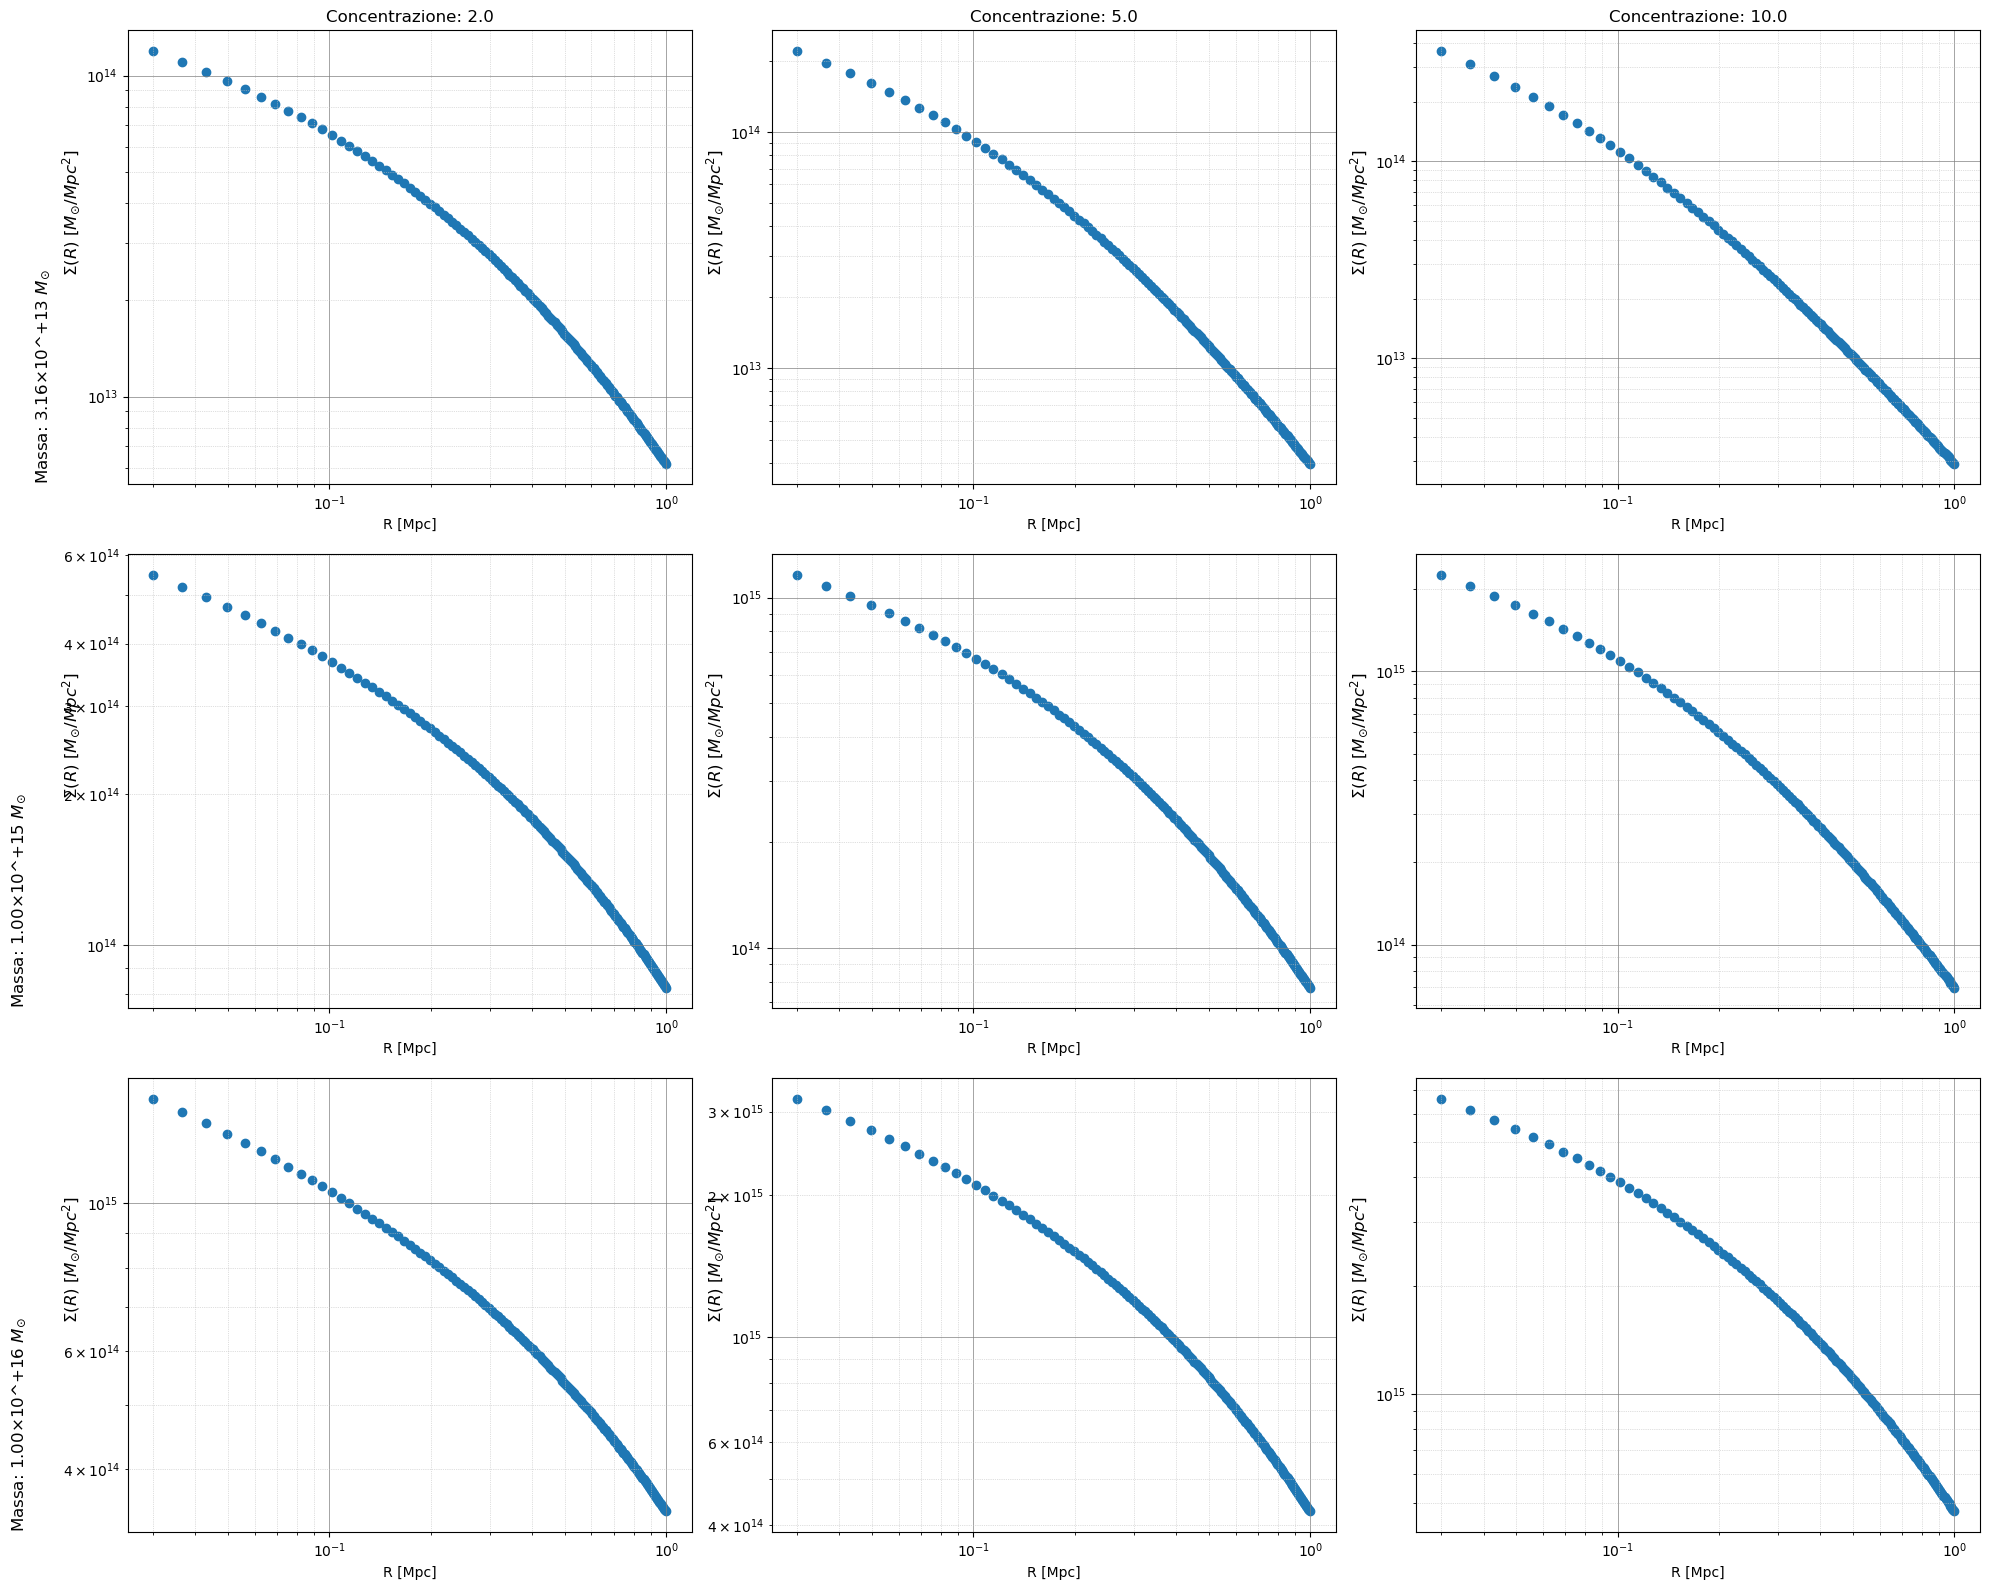

In [4]:
fig, ax = plt.subplots(len(M_values), len(c_values), figsize=(20,16))

for i in range(len(M_values)):
    ax[i, 0].set_ylabel(rf"Massa: {M_values[i]:.2e} $M_{{\odot}}$".replace('e', '×10^'), fontsize=12, rotation=90, labelpad=25, loc='bottom')
    # Label per le righe (il font è stato volutamente scelto così piccolo per problemi di spazio)

for j in range(len(c_values)):
    ax[0, j].set_title(f"Concentrazione: {c_values[j]}", rotation=0, fontsize=12, loc='center')
    # Label per le colonne (il font è stato volutamente scelto così piccolo per problemi di spazio)

for i in range(len(M_values)):
    for j in range(len(c_values)):
        ax[i,j].scatter(R, NFW[i, j, :])
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].set_xlabel('R [Mpc]')
        ax[i,j].text(-0.1, 0.6, rf'$\Sigma(R)$ [$M_{{\odot}}$/$Mpc^2$]', ha='center', va='center', 
                     rotation=90, fontsize=12, transform=ax[i,j].transAxes) # Label sugli assi y
        ax[i,j].minorticks_on()
        ax[i,j].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
        ax[i,j].grid(which='minor', color='silver', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

Per problemi di mancanza di spazio la visualizzazione dei grafici non è ottimale, quindi conviene analizzarli singolarmente. In questa serie di plot, ogni grafico è stato ottenuto calcolando $\Sigma(R,M,c,z)$ a partire da una coppia di valori $(M, c)$ tra quelle definite sopra e, a fianco ad esso, vengono fatti stampare i corrispondenti valori del raggio caratteristico $r_s$ e della densità caratteristica $\rho_s$.

<IPython.core.display.Latex object>

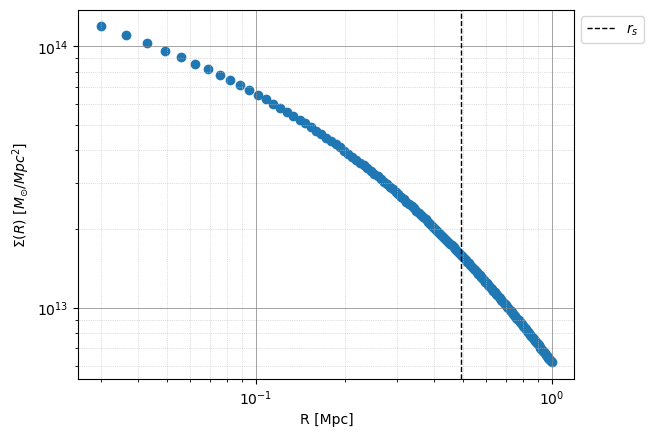

<IPython.core.display.Latex object>

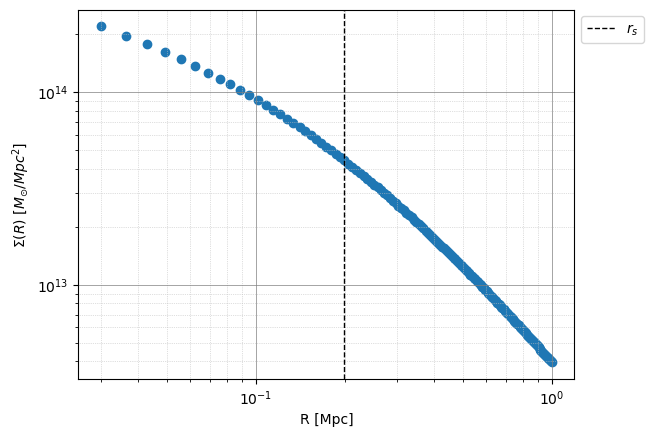

<IPython.core.display.Latex object>

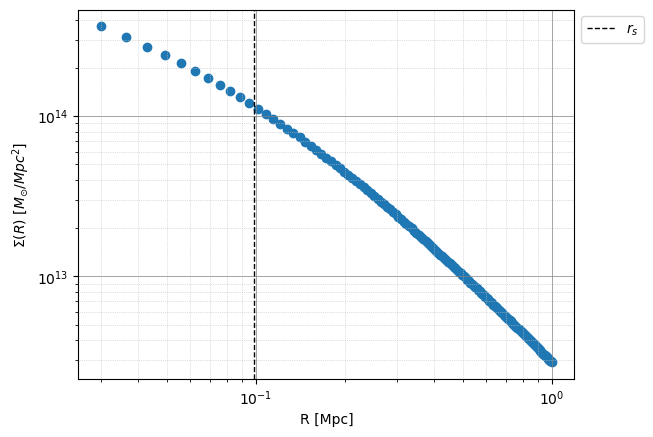

<IPython.core.display.Latex object>

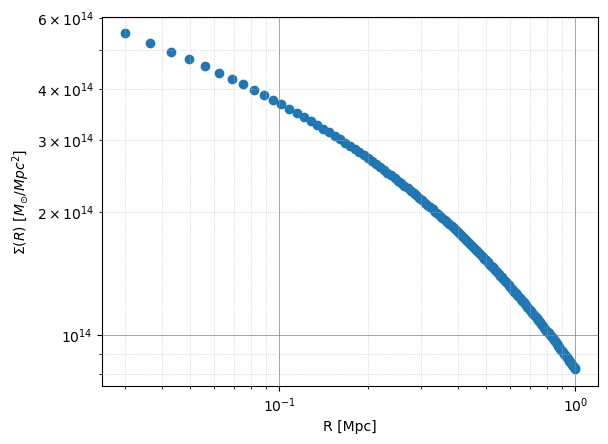

<IPython.core.display.Latex object>

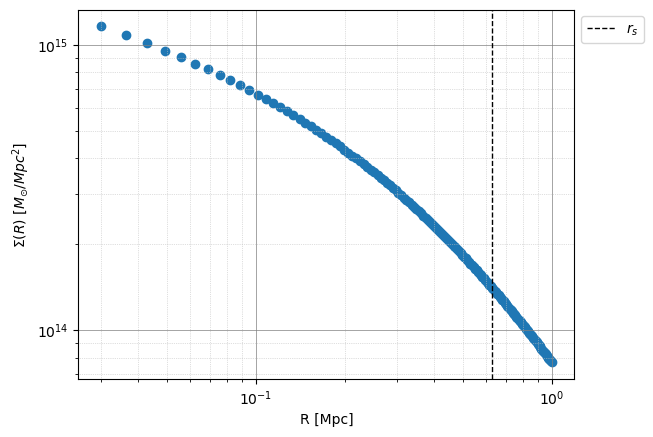

<IPython.core.display.Latex object>

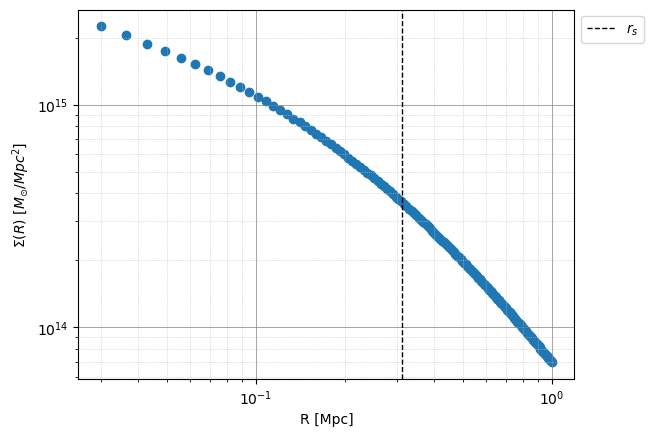

<IPython.core.display.Latex object>

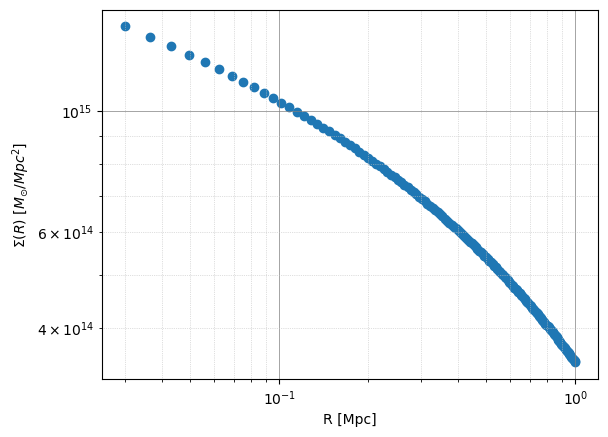

<IPython.core.display.Latex object>

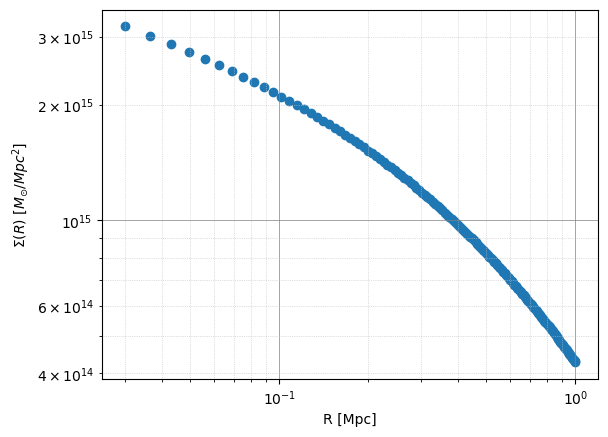

<IPython.core.display.Latex object>

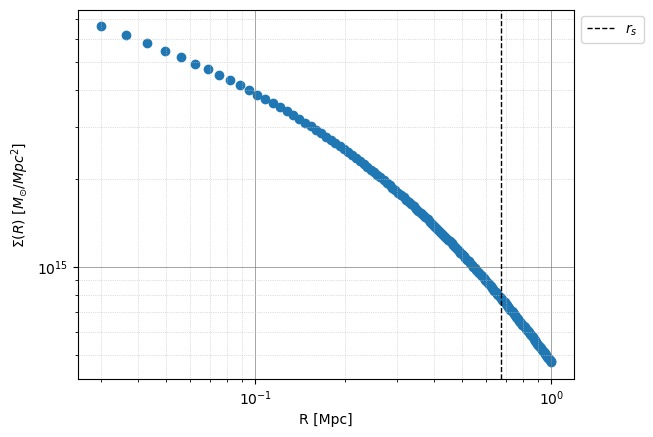

In [5]:
r_s = np.zeros((len(M_values), len(c_values)))
rho_s = np.zeros(len(M_values))

for i in range(len(M_values)):
    for j in range(len(c_values)):
        r_s[i,j] = raggio_caratt(z, M_values[i], c_values[j]) # Calcolo del raggio caratteristico
        rho_s[j] = densità_caratt(z, c_values[j]) # Calcolo della densità caratterisitca
        display(Latex(r"Massa: {:.4E} $M_{{\odot}}$, Concentrazione: {}, Raggio caratteristico: {:.4E} $Mpc$, Densità caratteristica: {:.4E} $M_{{\odot}}$/$Mpc^3$"
              .format(M_values[i], c_values[j], r_s[i, j], rho_s[j]).replace('E', '×10^'))) # Print dei risultati
        
        plt.scatter(R, NFW[i, j, :])
        if 0.03<r_s[i,j]<1.0:  # Se r_s appartiene all'intervallo in cui R è definito, viene rappresentato nel grafico
            plt.axvline(r_s[i,j], linestyle='--', color='black', linewidth=1, label=r'$r_s$')
            plt.legend(loc='upper left', bbox_to_anchor=(1.,1.))
            
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('R [Mpc]')
        plt.ylabel(r'$\Sigma(R)$ [$M_{{\odot}}$/$Mpc^2$]')
        plt.minorticks_on()
        plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
        plt.grid(which='minor', color='silver', linestyle=':', linewidth=0.5)
        plt.show()

# Lettura e visualizzazione dei dati dai file

#### File `R_values.npy`

Il primo file di dati da utilizzare per l'analisi, `R_values.npy`, contiene 8 valori di distanza $R$ (in $Mpc$). Per leggere un file con estensione *.npy*, è possibile utilizzare la funzione built-in di numpy *load* (per ulteriori informazioni su questa funzione, è possibile consultare la documentazione della libreria numpy al link https://numpy.org/doc/2.1/reference/generated/numpy.load.html#numpy.load).

In [6]:
filename1 = 'R_values.npy'
R_values = np.load(filename1, allow_pickle=True)

# Visualizzazione del contenuto del file
print('Numero di dati presenti nel file:', len(R_values))
print(R_values)

Numero di dati presenti nel file: 8
[0.04056329 0.06397266 0.10089175 0.15911711 0.25094477 0.39576683
 0.62416676 0.98437798]


#### File `halo_catalog.fit`

Per poter aprire e leggere il secondo file di dati, `halo_catalog.fit`, è necessario utilizzare il pacchetto *io.fits* fornito dalla libreria astropy (per maggiori informazioni, è possibile consultare la documentazione della libreria astropy al link https://docs.astropy.org/en/latest/io/fits/index.html#module-astropy.io.fits).  
In generale, il formato *.fit* o *.fits* è uno standard per l'archiviazione di dati astronomici e può contenere più sezioni, dette HDUs (ossia *Header/Data Units*), ciascuna con i propri header e con i propri dati. 

In [7]:
filename2 = 'halo_catalog.fit'
file_dati = fits.open(filename2)
file_dati.info() # Print a schermo delle informazioni sul file

tabella_dati = file_dati[1].data # Estrazione dei dati dal file (da BinTableHDU)

file_dati.close() # Chiusura del file

Filename: halo_catalog.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     14   40103R x 3C   [E, E, 8E]   


Facendo stampare a schermo le informazioni sul file, si osserva che al suo interno sono presenti due HDUs:

- **PrimaryHDU** è l'HDU principale che contiene informazioni generali sul file e metadati;
- **BinTableHDU** è una tabella con 40103 righe e 3 colonne di dati.

Estraendo i dati nel file, si osserva che nelle tre colonne sono contenuti rispettimente dei valori di redshift $z$, dei valori di ricchezza $\lambda$ (ossia delle somme pesate del numero di galassie che popolano un alone, che fungono da *proxy* per la massa) e un insieme di array, ognuno contenente 8 valori del profilo di densità dell'alone, calcolati in corrispondenza dei valori di $R$ estratti dal file precedente.

In [8]:
print(tabella_dati.names) # Print a schermo del contenuto delle colonne

# Estrazione dei dati dalle colonne
redshift = tabella_dati['Z']
ricchezza = tabella_dati['LAMBDA_TR']
profilo_densità = tabella_dati['SIGMA_of_R']

['Z', 'LAMBDA_TR', 'SIGMA_of_R']


Prima di procedere, è opportuno controllare che i set di dati estratti dal file siano tutti degli array numpy e che ogni elemento estratto dalla terza colonna sia a sua volta un array contenente 8 valori scalari.

In [9]:
print(type(redshift), type(ricchezza), type(profilo_densità)) # Print del data-type dei dati
print(profilo_densità.shape) # Print delle dimensioni di profilo_densità (matrice 40103x8)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(40103, 8)


#### File `covariance_matrices.npy`

Il terzo file di dati, `covariance_matrices.npy`, è di nuovo un file con estensione *.npy* e contiene le matrici di covarianza che verranno utilizzate successivamente nella fase di stima dei parametri.

In [10]:
filename3 = 'covariance_matrices.npy'
cov = np.load(filename3, allow_pickle=True)
print(cov.shape) # Print delle dimensioni del set di matrici di covarianza (5 matrici 8x8)

(5, 8, 8)


## Definizione degli intervalli di ricchezza e calcolo dei profili medi

Per poter trattare i dati estratti dal catalogo, si procede a suddividerli in 5 intervalli di ricchezza, aventi come estremi $\lambda = [15, 20, 30, 45, 60, 200]$. Per fare ciò, si estraggono gli indici dei valori di ricchezza appartenenti a ciascun intervallo mediante la funzione *numpy.where* e, a partire da questi, si suddividono i dati rimanenti (ossia i valori dei redshift e dei profili di densità) nei corrispondenti intervalli.

In [11]:
# Estrazione degli indici degli elementi in ciascun intervallo
intervallo_1 = np.where((ricchezza>=15) & (ricchezza<20))[0]
intervallo_2 = np.where((ricchezza>=20) & (ricchezza<30))[0]
intervallo_3 = np.where((ricchezza>=30) & (ricchezza<45))[0]
intervallo_4 = np.where((ricchezza>=45) & (ricchezza<60))[0]
intervallo_5 = np.where((ricchezza>=60) & (ricchezza<200))[0]
intervalli = [intervallo_1, intervallo_2, intervallo_3, intervallo_4, intervallo_5]

# Print del numero di dati contenuti in ogni intervallo
for i, interv in enumerate(intervalli):
    print('Intervallo {}:'.format(i+1), len(interv))

# Inizializzazione di liste per contenere i dati in ciascun intervallo
ricchezze = []
redshifts = []
matrici_densità = []

# Suddivisione dei redshift e dei profili di densità negl iintervalli
for interv in intervalli:
    ricchezze.append(ricchezza[interv])
    redshifts.append(redshift[interv])
    matrici_densità.append(profilo_densità[interv, :]) # Seleziona le righe in [interv] e tutte le colonne

Intervallo 1: 10185
Intervallo 2: 13131
Intervallo 3: 5791
Intervallo 4: 1565
Intervallo 5: 1018


Per ognuno di questi intervalli di ricchezza, si calcola il **valor medio** del **redshift $z$**.

In [12]:
z_medi = []
for i in range(len(intervalli)):
    z_m = np.mean(redshifts[i])
    print('Intervallo {}: z = {}'.format(i+1, z_m))
    z_medi.append(z_m)

Intervallo 1: z = 0.4600900411605835
Intervallo 2: z = 0.46388739347457886
Intervallo 3: z = 0.4592076539993286
Intervallo 4: z = 0.45643922686576843
Intervallo 5: z = 0.4411607086658478


Allo stesso modo, per ognuno di questi intervalli di ricchezza, si calcola il **profilo di densità medio** (in corrispondenza di ognuno dei valori di R) e la deviazione standard ad esso associato. Per determinare il profilo di densità medio, è possibile utilizzare la funzione *numpy.mean*, mentre per trovare il corretto errore da associare ad esso è necessario calcolare la deviazione standard dei diversi profili contenuti all'interno dell'intervallo (per fare ciò si utilizza la funzione *numpy.std* al link https://numpy.org/doc/stable/reference/generated/numpy.std.html#numpy.std) e dividere questa per la radice quadrata del loro numero.

Infatti, date N misure con valor medio $\mu$ e deviazione standard $\sigma$, la deviazione standard della loro media, ossia l'errore ad essa associato, può essere ottenuta mediante la formula:
$$\sigma_{mean} = \frac{\sigma}{\sqrt{N}} $$

In [13]:
profili_med = []
profili_dev = []
profili_err = []
for i in range(len(intervalli)):
    densità = matrici_densità[i]
    profilo_med = np.mean(densità, axis=0) # Profilo di densità medio
    profilo_dev = np.std(densità, axis=0) # Deviazione standard dei dati (profili di densità nell'i-esimo intervallo)
    profilo_err = profilo_dev / np.sqrt(densità.shape[0]) # Errore associato al profilo di densità medio
    profili_med.append(profilo_med)
    profili_dev.append(profilo_dev)
    profili_err.append(profilo_err)

## Plot dei profili medi di densità

A questo punto, è possibile costruire un grafico con 5 pannelli per rappresentare l'andamento del profilo di densità medio in funzione di $R$. Ogni pannello mostra gli 8 valori del profilo di densità medio in funzione di $R$ con il relativo errore, ottenuti a partire dai dati contenuti in ognuno dei 5 intervalli di ricchezza definiti sopra. Anche in questo caso, è conveniente utilizzare la scala logaritmica per migliorare la visualizzazione.

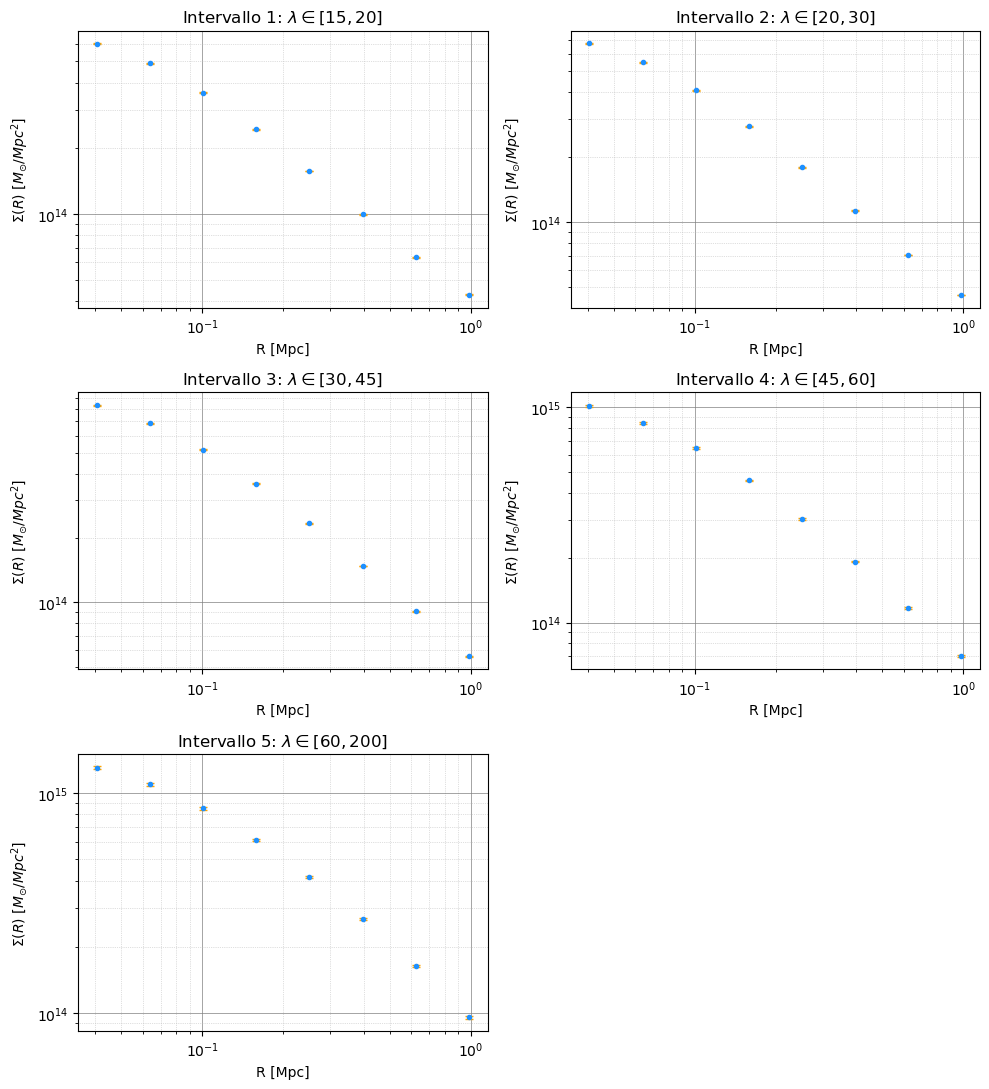

In [14]:
plt.figure(figsize=(10, 11))
titoli = [r'$\lambda\in[15,20]$', r'$\lambda\in[20,30]$', r'$\lambda\in[30,45]$', r'$\lambda\in[45,60]$', r'$\lambda\in[60,200]$']

for i in range(len(intervalli)):
    plt.subplot(3, 2, i+1)
    plt.errorbar(R_values, profili_med[i], yerr=profili_err[i], fmt='.', color='dodgerblue', ecolor='orange', capsize=3)
    plt.xscale('log')
    plt.yscale('log')
    plt.title("Intervallo {}: {}".format(i+1, titoli[i]))
    plt.xlabel('R [Mpc]')
    plt.ylabel(r'$\Sigma(R)$ [$M_{{\odot}}$/$Mpc^2$]')
    plt.minorticks_on()
    plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    plt.grid(which='minor', color='silver', linestyle=':', linewidth=0.5)

plt.subplot(3, 2, 6)
plt.axis('off')
plt.tight_layout()
plt.show()

Si osserva che i valori medi del profilo di densità e i corrispondenti errori differiscono di circa 2-3 ordini di grandezza. Questo accade perchè, nel calcolare l'errore associato alla media, è necessario dividere la deviazione standard dei dati (di circa un ordine di grandezza inferiore al loro valor medio) per la radice quadrata del numero di elementi contenuti in ogni intervallo, la quale assume valori relativamente grandi (compresi tra $\sim 30$ e $\sim 100$). In altre parole, disponendo di un gran numero di dati e stimando il loro valor medio, si ottiene un valore molto preciso, con un errore associato molto piccolo.

# Analisi dei dati e stima dei parametri $\log_{10}M$ e $c$

Utilizzando i dati estratti dal catalogo, le matrici di covarianza importate precedentemente e la funzione `NFW_profile` definita all'inizio, si vuole applicare l'algoritmo *EMCEE* per stimare i parametri $\log_{10} M$ e $c$ che meglio descrivono i dati contenuti all'interno di ogni intervallo di ricchezza.

L'**algoritmo EMCEE** è un'implementazione efficiente del *metodo di campionamento Metropolis-Hastings a MCMC* (ossia Markov Chain Monte Carlo), utilizzato nell'ambito dell'analisi statistica bayesiana per trattare problemi di inferenza statistica. Tale algoritmo si basa su un insieme di "camminatori" (detti *walkers*), che esplorano lo spazio dei parametri in maniera coordinata, migliorando l'efficienza del campionamento e riducendo la dipendenza dalla scelta delle condizioni iniziali.

Per trattare il problema, si considera come campione di dati da analizzare il set di profili di densità contenuti in ognuno degli intervalli di ricchezza precedentemente definiti; ogni elemento di tale campione di dati può essere inteso come un'osservazione delle 8 variabili casuali $\Sigma(R_1)$, ..., $\Sigma(R_8)$, la cui relazione è definita dalle matrici di covarianza contenute nel file `covariance_matrice.npy` e a cui corrispondono i valori di distanza $R_1$, ..., $R_8$ memorizzati nel file `R_values.npy`.

## Preparazione delle matrici di covarianza

Le 5 matrici di covarianza da utilizzare in questa fase, una per ognuno dei 5 intervalli di ricchezza, sono state importate precedentemente. È possibile visualizzare queste matrici di covarianza e osservare che hanno la forma di matrici diagonali: questo significa che le variabili casuali $\Sigma(R_1)$, ..., $\Sigma(R_8)$ non sono tra loro correlate.

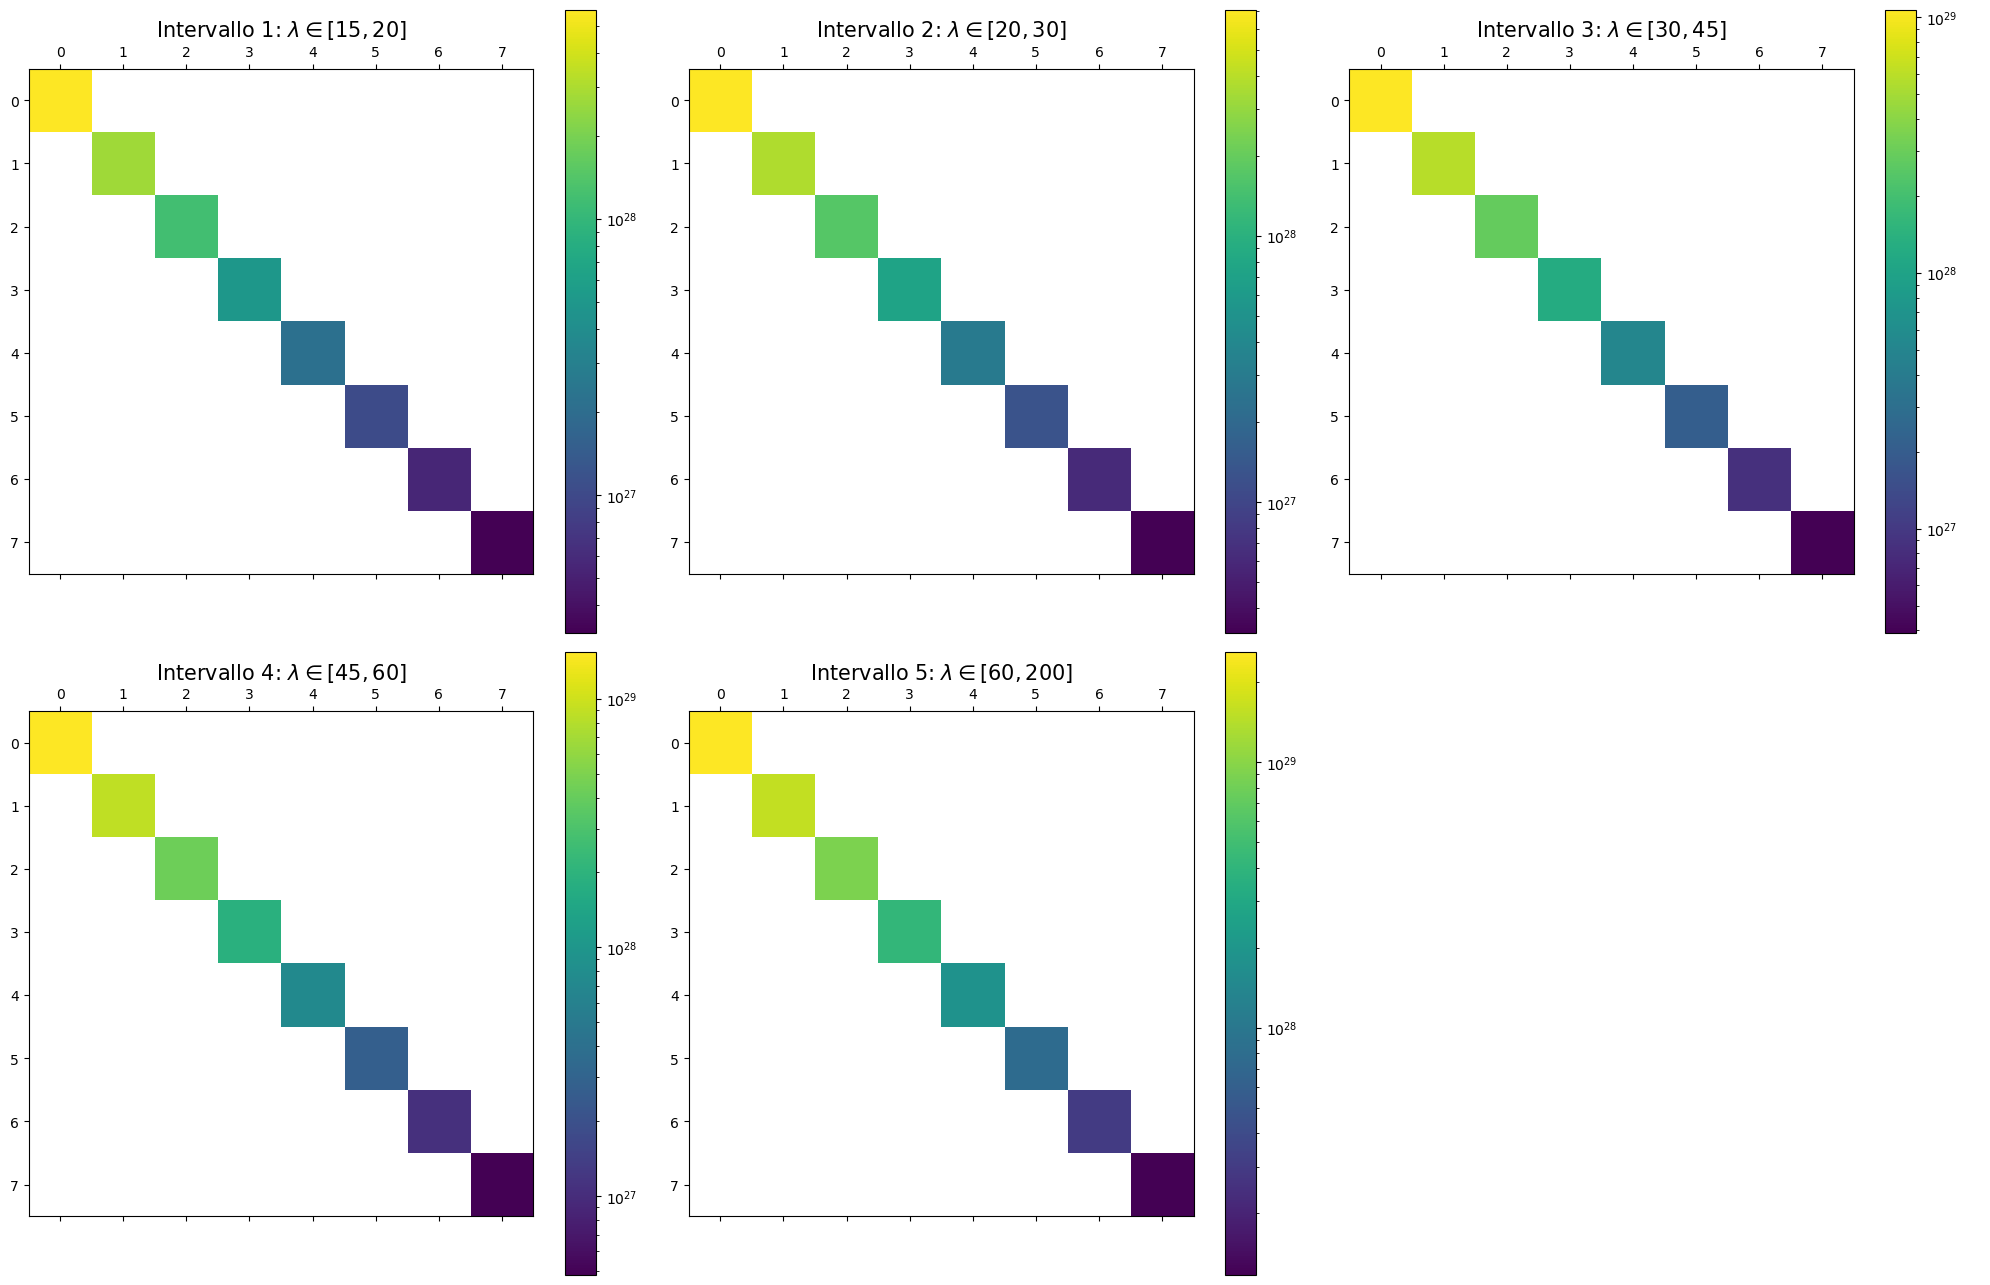

In [15]:
covarianze = []
plt.figure(figsize=(20, 13))

for i in range(len(intervalli)):
    covarianza = cov[i, :, :]
    covarianze.append(covarianza)
    ax = plt.subplot(2, 3, i+1)
    im = ax.matshow(covarianze[i], norm=LogNorm())
    ax.set_title("Intervallo {}: {}".format(i+1, titoli[i]), fontsize=15)
    plt.colorbar(im, ax=ax)

plt.subplot(2, 3, 6)
plt.axis('off')
plt.tight_layout()
plt.show()

È conveniente invertire già ora queste matrici di covarianza, perchè nel corso dell'analisi risulteranno necessarie le matrici inverse. Per fare ciò, è possibile utilizzare la funzione *numpy.linalg.inv* offerta dalla libreria numpy.

In [16]:
covarianze_inverse = []

for i in range(len(intervalli)):
    covarianza_inversa = np.linalg.inv(covarianze[i])
    covarianze_inverse.append(covarianza_inversa)

## Definizione delle funzioni log-prior, log-likelihood e log-posterior

Il primo step nell'implementazione dell'algoritmo *EMCEE* consiste nel definire le seguenti funzioni:

- Un **PRIOR**, ossia una funzione che, fissato un determinato modello, fornisce informazioni iniziali sui parametri. In questo caso, si sceglie di utilizzare un *prior uniforme*, tale che vincoli il parametro $\log_{10}M$ ad assumere valori nell'intervallo $[13, 16]$ e faccia sì che il parametro $c$ appartenga all'intervallo $[0.2, 20]$.
- Un **LIKELIHOOD**, ossia la distribuzione di probabilità seguita dai dati nel caso in cui un modello e dei parametri risultino fissati. In questo caso, si assume un *likelihood gaussiano* 8-dimensionale avente la forma:
$$ \mathcal{L} = \frac{1}{\sqrt{(2\pi)^k\det(C)}}e^{-\frac{1}{2}\left[(\Sigma(R)-\Sigma_{th}(R, M, c, z))^T \cdot C^{-1}\cdot(\Sigma(R)-\Sigma_{th}(R, M, c, z))\right]} $$
Qui $C$ si riferisce alla matrice di covarianza di cui sopra, $\Sigma(R)$ indica l'insieme delle 8 variabili causali $\Sigma(R_1)$, ..., $\Sigma(R_8)$ corrispondenti alle 8 distanze $R_1$, ..., $R_8$, mentre $\Sigma_{th}(R, M, c, z)$ è l'insieme di valori del profilo di densità che si ottengono applicando a questi valori di distanza la funzione `NFW_profile` definita sopra (i parametri $M$ e $c$ verranno stimati di seguito, mentre il parametro $z$ si considera fissato e viene posto uguale al valor medio del redshift calcolato per ogni intervallo di ricchezza).
- Un **POSTERIOR**, ossia una funzione che descrive la probabilità dei parametri di assumere determinati valori, nel caso in cui il modello e i dati risultino fissati.
Il posterior può essere calcolato prendendo il prodotto tra il likelihhod e il prior; così facendo si omette un termine di normalizzazione non rilevante (si ottiene un prior corretto ma non normalizzato).

Per godere del vantaggio di lavorare con numeri non troppo grandi e di eseguire somme anzichè prodotti, si sceglie di considerare il logaritmo naturale delle funzioni prior, likelihood e posterior. In particolare, con questa scelta la funzione log-likelihood assume la forma:
$$\ln\mathcal{L} = -\frac{1}{2}\ln\left[(2\pi)^k\det(C)\right] - \frac{1}{2}\left[(\Sigma(R)-\Sigma_{th}(R, M, c, z))^T \cdot C^{-1}\cdot(\Sigma(R)-\Sigma_{th}(R, M, c, z))\right] $$
Si osserva che il primo termine della somma è una costante che non dipende dai parametri da stimare, quindi può essere omesso. Non considerando questo termine, il valore massimo della funzione di likelihood varia, ma i valori dei parametri che la massimizzano (cioè le stime da determinare) rimangono gli stessi.

<div style="border: 2px solid #ccc; padding: 10px; border-radius: 5px; background-color: #f9f9f9;">
    <b>NOTA TECNICA: Implementazione della funzione <code>log_likelihood</code>. </b>  <br><br>
    Il campione di dati da utilizzare per l'analisi è organizzato negli array numpy <code>matrici_densità[i]</code> (con <code>i</code> compreso tra 0 e 4). Ciascun array ha la forma di una matrice bidimensionale con un numero di righe pari al numero di elementi contenuti all'interno di ogni intervallo e con 8 colonne. Per far sì che la funzione <code>log_likelihood</code> catturi tutta l'informazione racchiusa nel set di dati, è necessario sommare i valori assunti dalla funzione di likelihhod (o megio, dal suo logaritmo) in corrispondenza di ogni osservazione, ossia su ciascuna delle righe della matrice. Per trasformare questo in un codice python funzionante e ottimizzato, si procede nel modo seguente:
    <ol>
    <li>Si calcola la matrice <code>residui</code> sottraendo ad ogni riga delle matrici contenenti i dati sempre lo stesso array <code>y_th</code>, mediante un'operazione di <i>broadcasting</i>.</li>
    <li>Si  calcolano i contributi individuali alla funzione di log-likelihood per ogni osservazione. Per fare ciò, per prima cosa si esegue il prodotto matriciale tra <code>residui</code> (di dimensione <code>len(interv)</code>x8) e l'inversa della matrice di covarianza (di dimensione 8x8), ottenendo una matrice risultante di dimensione <code>len(interv)</code>x8. A questo punto, si esegue il prodotto elemento per elemento tra la matrice risultante e <code>residui</code> e si somma sulle colonne, ottenendo un array numpy 1D contenente i valori del log-likelihhod associati ad ogni osservazione.  <br>
Questo equivale a eseguire in successione i prodotti tra matrici <code>residui @ inv_cov @ residui.T</code> e a considerare solo gli elementi diagonali della matrice risultante (questo perchè non si vuole mescolare due osservazioni differenti); quest'altra soluzione però, seppur equivalente alla precedente a livello di risultati, è di gran lunga meno efficiente in termini di tempo di esecuzione del codice.  </li>
    <li>Si sommano tutti i contributi individuali alla funzione di log-likelihood calcolati nel punto precedente, ottenendo il logaritmo della funzione di likelihood da utilizzare negli step successivi dell'analisi.</li>
    </ol> 
</div>

In [17]:
def log_prior(parametri):
    logM, c = parametri
    if 13.0<=logM<=16.0 and 0.2<=c<=20.0:
        return 0.0  # Ossia ln(1)
    return -np.inf  # Ossia ln(0)

def log_likelihood(parametri, z, x, y_matrice, inv_cov):
    logM, c = parametri  # Parametri da stimare
    M = 10**logM  # Parametro necessario per calcolare y_th
    y_th = NFW_profile(x, M, c, z)
    residui = y_matrice - y_th  # Ad ogni riga della matrice viene sottratto l'array y_th
    logL_individual = -0.5 * np.sum((residui @ inv_cov) * residui, axis=1)
    #logL_individual = -0.5 * np.diag(residui @ inv_cov @ residui.T)
    logL = np.sum(logL_individual)
    return logL

def log_posterior(parametri, z, x, y_matrice, inv_cov): # Non normalizzato
    logPrior = log_prior(parametri)
    if not np.isfinite(logPrior):
        return -np.inf
    return logPrior + log_likelihood(parametri, z, x, y_matrice, inv_cov)

## Algoritmo EMCEE

Prima di eseguire il campionamento EMCEE vero e proprio, si ricercano dei buoni valori iniziali per i parametri attraverso una **massimizzazione** del **posterior**. In questo modo, i camminatori che andranno a comporre la catena Markov dell'algoritmo EMCEE potranno iniziare il loro campionamento da dei valori dei parametri non troppo lontani dai valori di best fit che si otterranno, la dispersione iniziale della catena sarà minore e il processo di convergenza verrà accelerato.  
Per fare ciò, si definisce una funzione `lambda` che riceve in input un numero arbitrario di argomenti e restituisce come output il valore del posterior cambiato di segno. Definita tale funzione, la si può minimizzare ricorrendo al pacchetto *optimize.minimize* della libreria scipy: minimizzare la funzione `lambda` equivale a massimizzare il likelihood (e di conseguenza il posterior) e dunque permette di ottenere dei valori ottimizzati per i parametri da cui far partire il campionamento.

In [18]:
nll = lambda *args: -log_posterior(*args) # Definizione della funzione lambda

soln_lista = []
bounds = [(13., 16.), (0.2, 20.)]  # Si pongono di nuovo dei bound sui parametri per facilitare la convergenza
for i in range(len(intervalli)):
    initial = np.array([14.5, 10.])*(1+0.1*np.random.randn(2))
    soln = minimize(nll, initial, args=(z_medi[i], R_values, matrici_densità[i], covarianze_inverse[i]), bounds=bounds)
    logM_i, c_i = soln.x # Valori ottenuti per i parametri
    soln_lista.append(soln)
    print('Intervallo {}:'.format(i+1), soln.x, soln.message) # Print dei valori ottenuti e dello stato della convergenza

Intervallo 1: [14.33028373  2.67711622] CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Intervallo 2: [14.40885258  2.7977342 ] CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Intervallo 3: [14.56837276  3.06710877] CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Intervallo 4: [14.72062509  3.31349802] CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Intervallo 5: [14.92337923  3.57161789] CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


A questo punto è possibile procedere con il **campionamento EMCEE** vero e proprio. Si parte con l'inizializzazione delle seguenti variabili:

- `n_dim`: dimensione dello spazio dei parametri, ossia numero dei parametri da stimare.
- `n_walkers`: numero di walkers utilizzati nel campionamento. Tendenzialmente il numeri di walkers utilizzati deve essere almeno uguale a $2\cdot n_{dim}+1$, anche se è preferibile scegliere un valore pari a $3\cdot n_{dim}$ o superiore. La scelta del numero di walkers può essere valutata e ottimizzata "a posteriori", guardando il trace plot associato ad ogni parametro e calcolando il tempo di autocorrelazione. In generale, un numero maggiore di walkers favorisce una migliore esplorazione dello spazio dei parametri e una riduzione della fase di burn-in, ma può comportare un aumento anche significativo del tempo di esecuzione del codice. 
- `n_steps`: numero di iterazioni che ogni walker esegue durante il campionamento. Anche questo valore può essere valutato e ottimizzato "a posteriori" guardando il trace plot associato ad ogni parametro.

In [19]:
n_dim = 2
n_walkers = 18
n_steps = 2500

Si esegue il campionamento EMCEE facendo partire la catena Markov dai valori ottimizzati dei parametri appena trovati. Tali valori vengono leggermente perturbati per evitare che tutti i walkers inizino il campionamento esattamente nello stesso punto; questa perturbazione però è piccola poichè i valori iniziali dei parametri sono già stati sottoposti ad un ciclo di ottimizzazione precedente.

In [20]:
sampler_lista = []

for i in range(len(intervalli)):
    pos = soln_lista[i].x + 0.001 * np.random.randn(n_walkers, n_dim)
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, 
                                    args=(z_medi[i], R_values, matrici_densità[i], covarianze_inverse[i]))
    sampler_lista.append(sampler)
    sampler.run_mcmc(pos, n_steps, progress=True);

100%|██████████| 2500/2500 [00:19<00:00, 130.90it/s]


Per verificare la buona riuscita del campionamento, è possibile visualizzare i **trace plots** associati ai parametri. Ognuno di questi grafici mostra il percorso compiuto dai walkers nello spazio dei parametri e permette di giudicare qualitativamente l'esito del campionamento e stimare il numero di campioni da includere nella fase di burn-in (ossia il numero di campioni da scartare perchè non ancora rappresentativi della distribuzione cercata).  
Prima di realizzare questi grafici, è necessario trasformare i campioni generati dal campionamento (il cui data-type è *emcee.ensemble. EnsembleSampler*) in array numpy aventi la forma $(n_{steps},\,n_{walkers},\,n_{dim})$. Per fare ciò è possibile utilizzare la funzione *get_chain* della libreria emcee.

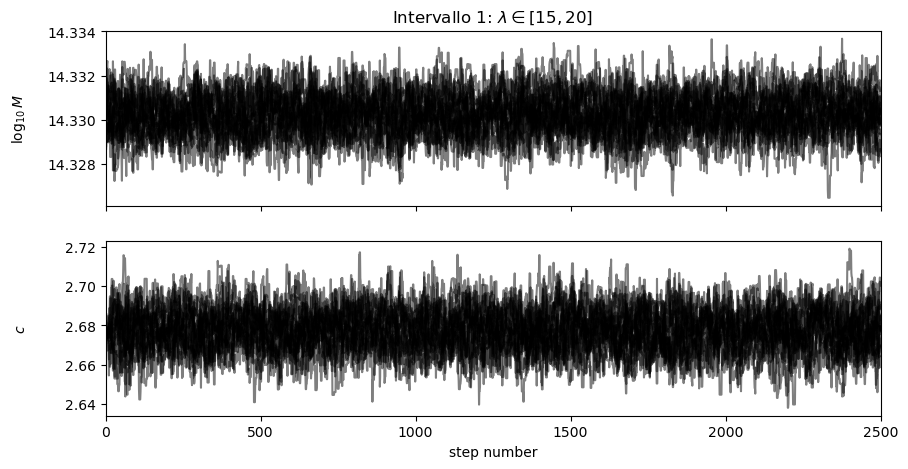

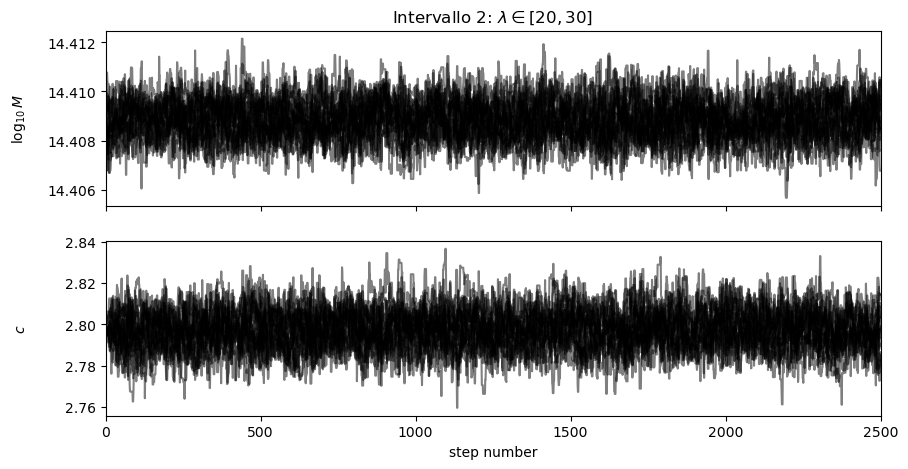

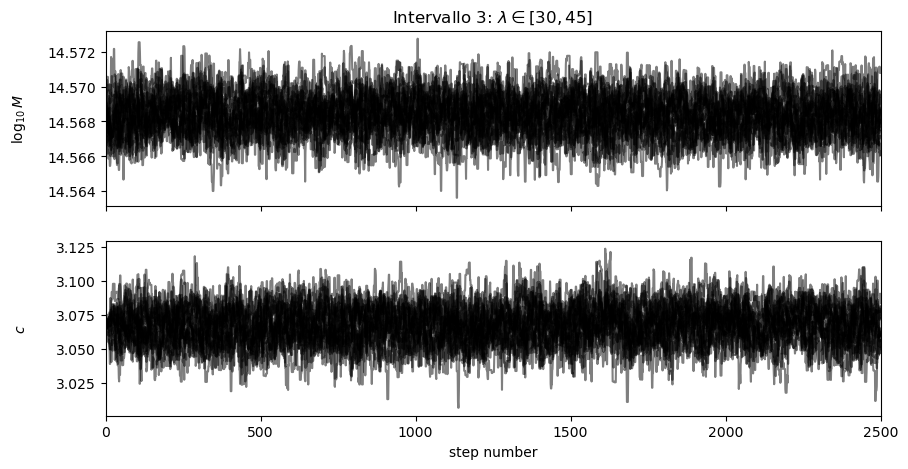

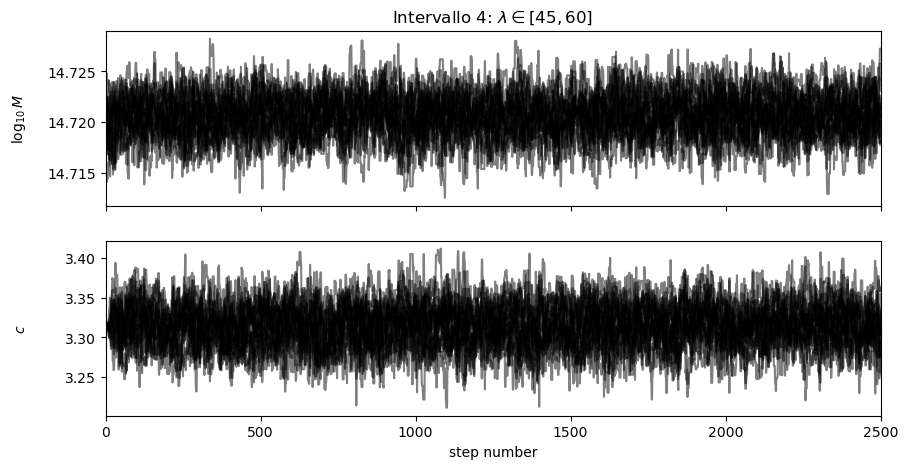

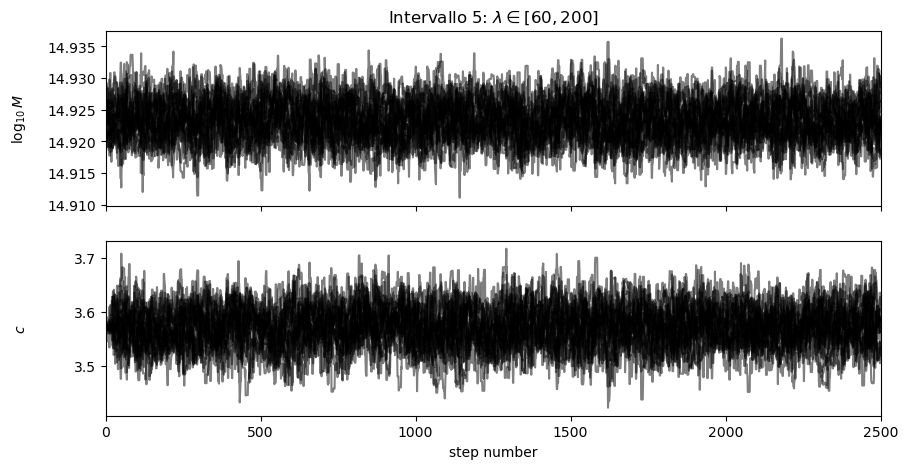

In [21]:
samples_lista = []

for i in range(len(intervalli)):
    samples = sampler_lista[i].get_chain()
    samples_lista.append(samples)
    
    fig, axes = plt.subplots(2, figsize=(10, 5), sharex=True)
    axes[0].set_title("Intervallo {}: {}".format(i+1, titoli[i]))
    labels = [r'$\log_{10}M$', r'$c$']
    names = ["log10M", "c"]
    for j in range(n_dim):
        ax = axes[j]
        ax.plot(samples[:, :, j], "k", alpha=0.5)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[j])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");
    plt.show()

Tali grafici sembrano mostrare che l'esito del campionamento è positivo: il trace plot risultante da una buona catena Markov dovrebbe apparire come rumore bianco e questo è proprio ciò che si vede nel grafico.  
Per disporre di un ulteriore strumento, oltre ai trace plots, che permetta di stimare il numero di campioni da includere nella fase di burn-in iniziale, è possibile calcolare il **tempo di autocorrelazione** associato ad ognuno dei parametri campionati: questo può essere considerato come una misura della lunghezza della "memoria" della catena e viene calcolato come la distanza, in termini di iterazioni, per cui i campioni contenuti nella catena si possono considerare efficacemente indipendenti. Un valore alto di `tau` implica che la catena presenta una forte correlazione tra i campioni e di consegienza si necessita di un numero maggiore di passi per ottenere campioni indipendenti, ossia si ha una fase di burn-in più lunga.

In [22]:
tau_lista = []

for i in range(len(intervalli)):
    tau = sampler_lista[i].get_autocorr_time()
    print("Intervallo {}:".format(i+1), tau)
    tau_lista.append(tau)

Intervallo 1: [27.38943694 31.78229945]
Intervallo 2: [26.33327212 26.53845554]
Intervallo 3: [31.13324758 29.97681743]
Intervallo 4: [28.27411968 28.6473817 ]
Intervallo 5: [30.94687877 28.17613834]


Osservando i traces plots dei parametri e i valori ottenuti per i tempi di autocorrelazione, sembra più che sufficiente incluedere solo i primi 100 campioni nella **fase di burn-in**. Si procede ora a rimuovere tali campioni e ad appiattire la catena, trasformandola in un array numpy 2D, in modo tale da poterla maneggiare più facilmente negli step successivi.

In [23]:
emcee_sample_lista = []
for i in range(len(intervalli)):
    emcee_sample = sampler_lista[i].get_chain(discard=100, flat=True)
    emcee_sample_lista.append(emcee_sample)

## Valori ottenuti per i parametri

Dopo aver performato l'algoritmo EMCEE, è possibile estrarre dalla catena il **valore di best-fit** dei parametri (ossia il valore all'interno della catena che massimizza il posterior) e il loro **valor medio**, con il corrispondente errore. È possibile, inoltre, confrontare tali valori per vedere se sono tra loro compatibili.  
Dato che i campioni che compongono la catena Markov non sono tra loro indipendenti (per definizione, infatti, una catena di Makrov è una successione di valori tale che un suo elemento dipende solo ed esclusivamente dall'elemento che lo precede), non è corretto calcolare il valor medio di ogni parametro e il suo errore utilizzando le funzioni *numpy.mean* e *numpy.std*. Per fare ciò, è possibile avvalersi di alcune funzioni offerte dalla libreria ***getdist***, la quale permette di ottenere dei corretti valori medi per i parametri, con il giusto errore associato.

In [24]:
getdist.chains.print_load_details = False 
# Forza la disattivazione dei messaggi (affinchè non venga stampato in output 'Removed no burn-in')

means_lista = []
stds_lista = []
bestfits_lista = []

for i in range(len(intervalli)):
    print("Intervallo {}:".format(i+1))
    means = np.zeros(n_dim)
    stds = np.zeros(n_dim)
    bestfits = np.zeros(n_dim)
    log_like = sampler_lista[i].get_log_prob(discard=100, flat=True) # Valori del log-posterior per ogni step della catena
    samples_plot = getdist.MCSamples(samples=emcee_sample_lista[i], names=names, labels=labels)

    for j in range(n_dim):
        stats = samples_plot.getMargeStats()
        means[j] = stats.parWithName(names[j]).mean  # Valor medio dei parametri
        stds[j] = stats.parWithName(names[j]).err  # Errore sul valor medio
        bestfits[j] = emcee_sample_lista[i][np.argmax(log_like), j] # Valore di best-fit dei parametri
        
        display(Latex(r'Valor medio di {}: ({:.4f} $\pm$ {:.4f})'.format(labels[j], means[j], stds[j])), 
                Latex('Valore di best fit di {}: {:.4f}'.format(labels[j], bestfits[j])))
        
    means_lista.append(means)
    stds_lista.append(stds)
    bestfits_lista.append(bestfits)

Intervallo 1:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Intervallo 2:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Intervallo 3:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Intervallo 4:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Intervallo 5:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Si osserva che i valori di best-fit ottenuti per i parametri sono tutti compatibili con i corrispondenti valori medi. Questo può essere interpretato come un primo segnale della buona riuscita dell'operazione di fit.

Oltre al calcolo dei valori medi e dei valori di best-fit per i parametri, è possibile realizzare dei **grafici triangolari** che mostrino la distribuzione del posterior associato ad ognuno dei parametri. Questo tipo di grafico permette di rappresentare anche l'*ellisse di degenerazione* dei due parametri e di valutarne qualitativamente la correlazione: in questo caso si osserva che il semiasse maggiore dell'ellisse ha una pendenza negativa e dunque ci si aspetta che i due parametri siano tra loro anticorrelati (ossia $-1\le\rho<0$).

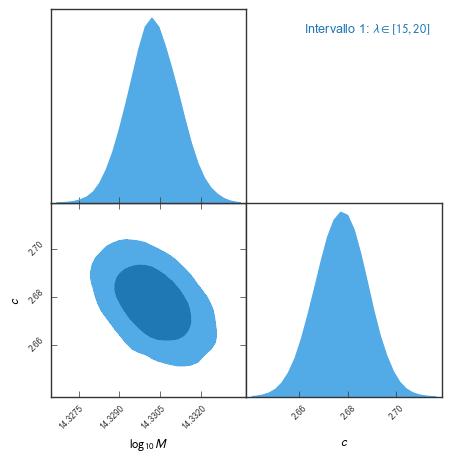

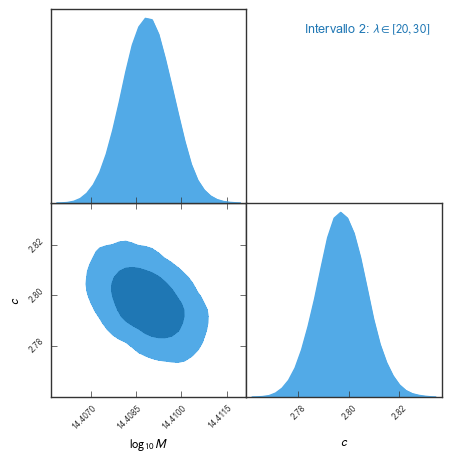

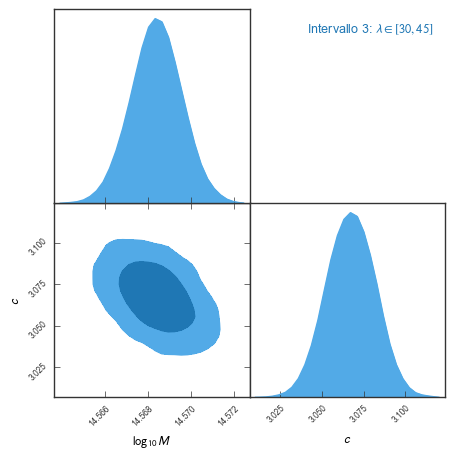

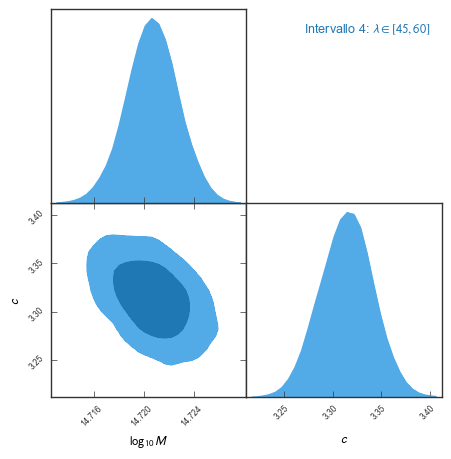

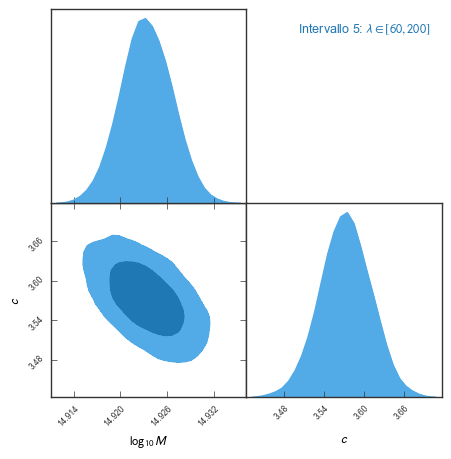

In [25]:
for i in range(len(intervalli)):
    GTC = pygtc.plotGTC(chains=emcee_sample_lista[i], paramNames=labels, 
                        chainLabels=['Intervallo {}: {}'.format(i+1, titoli[i])], figureSize='MNRAS_page')
    plt.show()

## Studio della correlazione tra i parametri

Il grafico triangolare realizzato sopra permette di valutare qualitativamente la correlazione tra due parametri. Se si vuole, invece, ottenere una stima quantitiativa del coefficiente di correlazione $\rho$, è possibile calcolare la **matrice di correlazione**, mediante un apposita funzione di numpy.

In [26]:
for i in range(len(intervalli)):
    corr_matrix = np.corrcoef(emcee_sample_lista[i].T)
    print("Matrice di correlazione relativa all'intervallo {}:".format(i+1))
    print(np.round(corr_matrix, 3))

Matrice di correlazione relativa all'intervallo 1:
[[ 1.    -0.471]
 [-0.471  1.   ]]
Matrice di correlazione relativa all'intervallo 2:
[[ 1.    -0.432]
 [-0.432  1.   ]]
Matrice di correlazione relativa all'intervallo 3:
[[ 1.    -0.453]
 [-0.453  1.   ]]
Matrice di correlazione relativa all'intervallo 4:
[[ 1.    -0.444]
 [-0.444  1.   ]]
Matrice di correlazione relativa all'intervallo 5:
[[ 1.    -0.575]
 [-0.575  1.   ]]


I valori ottenuti per i coefficienti di correlazione tra i parametri confermano quanto osservato sopra, ossia che $\log_{10}M$ e $c$ sono tra loro anticorrelati.

## Test della bontà del fit (confronto grafico tra dati e modelli e plot dei residui)

Per valutare se il modello che si è assunto descrive bene i dati e per verificare la bontà del fit, è possibile per prima cosa eseguire un **confronto** di tipo **grafico** tra il campione di dati utilizzato, il *best-fit model* (ossia il modello che si ottiene scegliendo i valori di best-fit dei parametri) e il modello definito a partire dai valori medi dei parametri. Per un miglior test della robustezza del modello scelto, è possibile aggiungere a questo confronto anche $\sim100$ ulteriori modelli ottenuti estraendo dalle catene dei valori di $\log_{10}M$ e $c$ in modo randomico.  
Nei grafici ripostati di seguito, sono rappresentati i profili di densità medi calcolati precedentemente (in nero), tutti i valori dei profili di densità che compongono il campione (in <span style="color:blue">blu</span>), le curve teoriche corrispondenti al modello di *best-fit* (in <span style="color:magenta">magenta</span>), al modello ottenuto a partire dai parametri medi (in <span style="color:green">verde</span>) e ai modelli costruiti a partire dai valori dei parametri estratti casualmente dalle catene (in <span style="color:orange">arancione</span>).

Oltre ad eseguire un confronto grafico tra il campione di dati e i modelli, è opportuno dare uno sguardo anche al **grafico dei residui**. In questo caso, i valori dei profili di densità contenuti nel campione variano su più ordini di grandezza e dunque, volendo considerare la loro differenza per il calcolo dei residui, gli scostamenti dei dati dai modelli teorici sarebbero meno immediati da interpretare. Per questo motivo, si sceglie di considerare la *percentuale di deviazione* dei dati dal modelli teorico e di calcolare i "residui" facendo il rapporto tra i valori del profilo di densità inclusi nel campione di dati e i corrispondenti valori previsti mediante il modello teorico NFW, ossia:
$$ \text{Residuo}= \frac{\Sigma(R)_{oss}}{\Sigma(R,M,c,z)_{th}} $$

Intervallo 1:


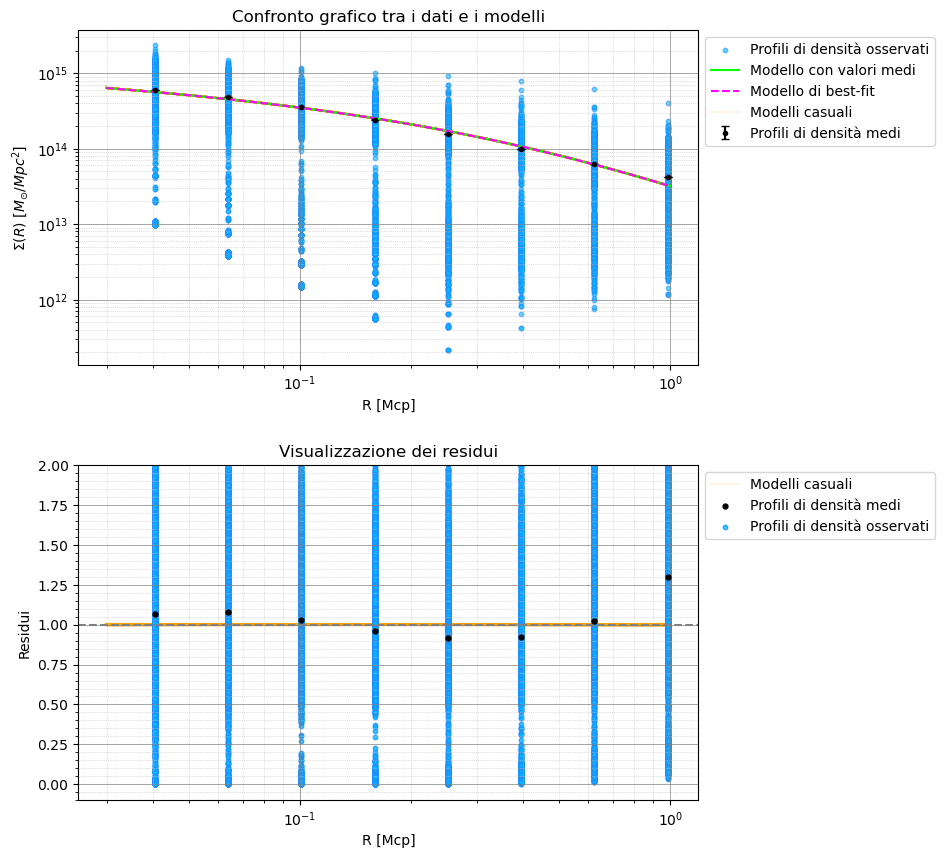

Intervallo 2:


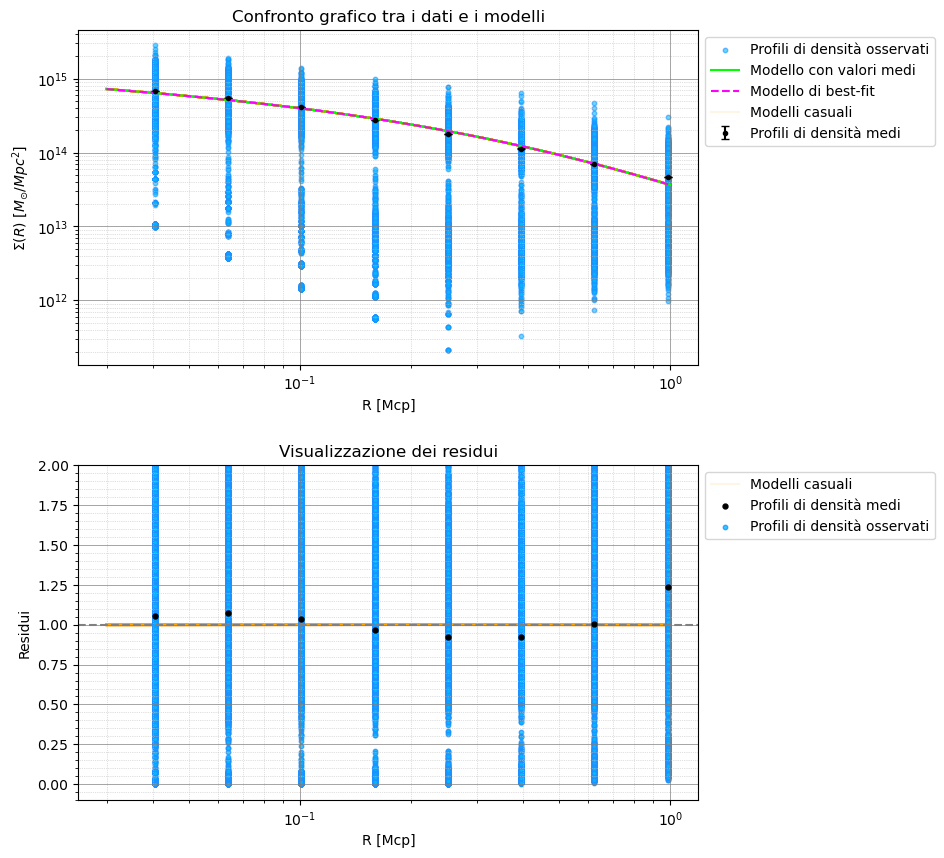

Intervallo 3:


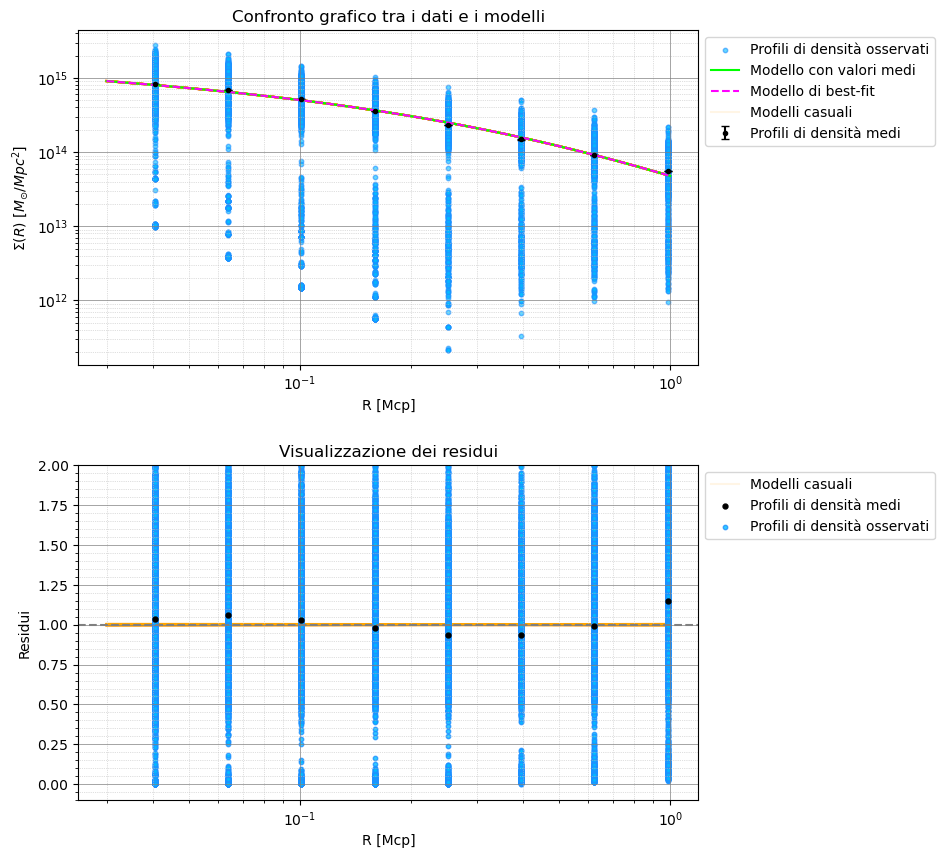

Intervallo 4:


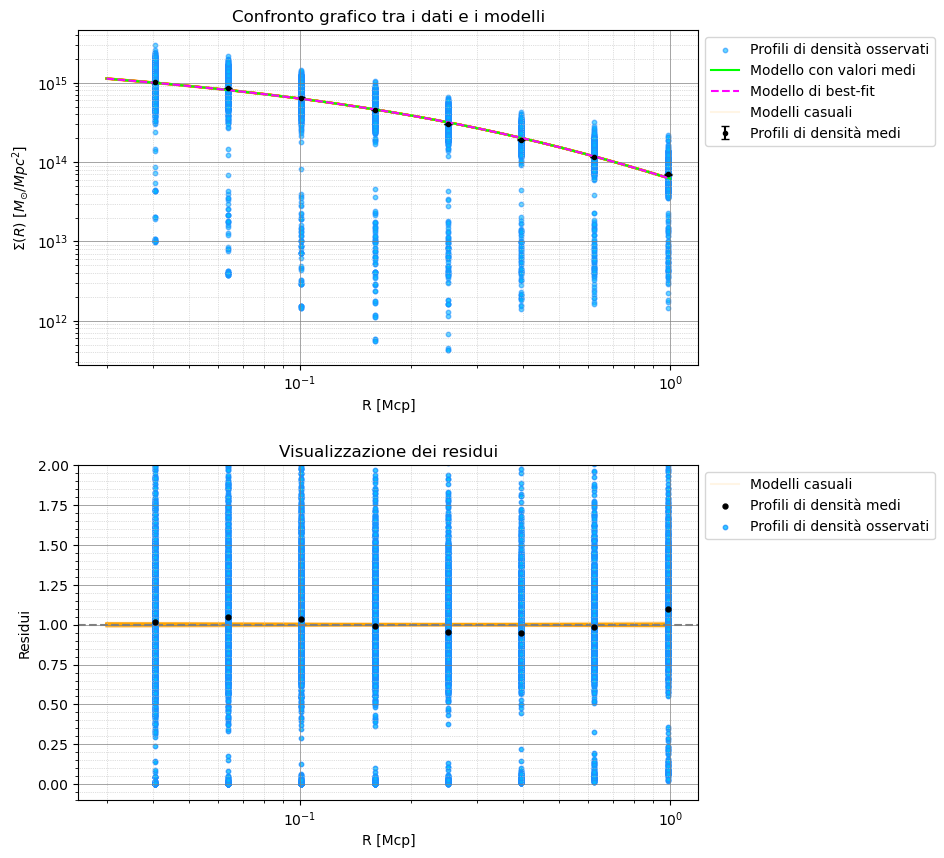

Intervallo 5:


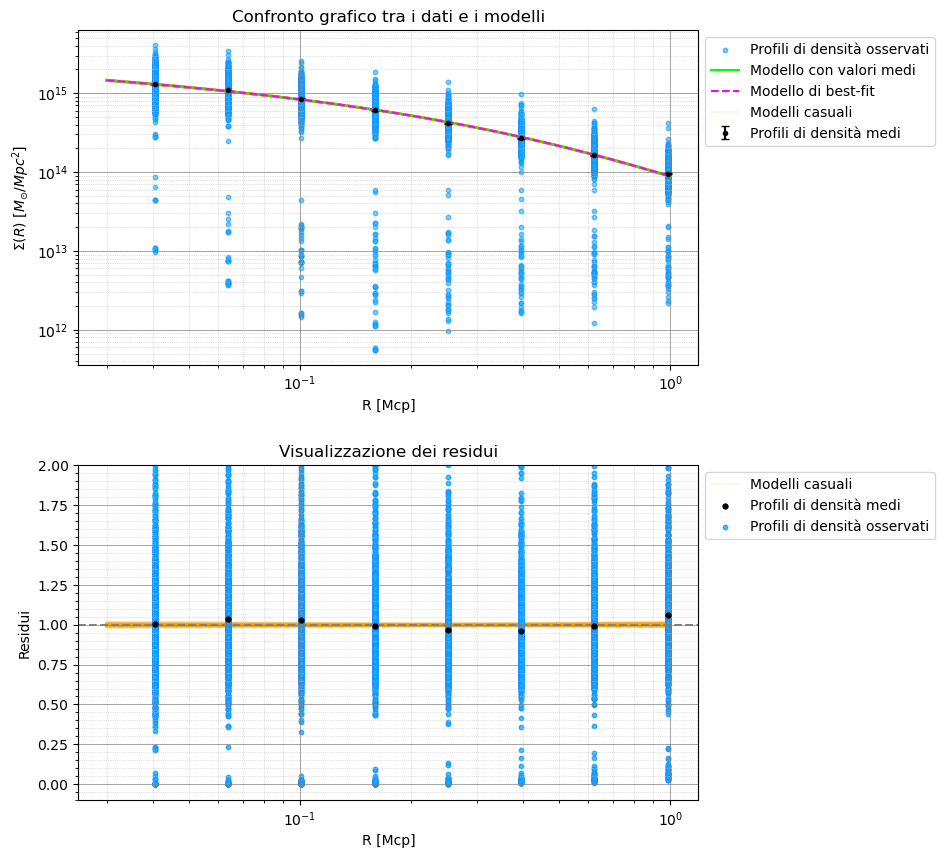

In [27]:
NFW_mean_lista = []
NFW_bestfit_lista = []
R_continuo = np.linspace(0.03, 1.0, 250) # Intervallo di valori in ascissa necessario per plottare le curve teoriche

for i in range(len(intervalli)):
    print("Intervallo {}:".format(i+1))
    
    # Si inizializzano 2 plot, uno per i modelli e uno per i residui
    fig, ax = plt.subplots(2, figsize=(8, 10)) 
    ax[0].errorbar(R_values, profili_med[i], yerr=profili_err[i], fmt='.', color='black', 
                   capsize=3, label='Profili di densità medi') # Plot profili di densità medi
    ax[0].scatter(np.tile(R_values, matrici_densità[i].shape[0]), # Ripetizione di R_values per ogni riga
                  matrici_densità[i].ravel(), facecolors='deepskyblue', edgecolor='dodgerblue', alpha=0.6,
                  marker='o', s=10, label='Profili di densità osservati') # Plot dei profili di densità osservati
    ax[0].set_title('Confronto grafico tra i dati e i modelli')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('R [Mcp]')
    ax[0].set_ylabel(r'$\Sigma(R)$ [$M_{{\odot}}$/$Mpc^2$]')
    ax[0].minorticks_on()
    ax[0].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax[0].grid(which='minor', color='silver', linestyle=':', linewidth=0.5)
    
    # Modello con valori medi dei parametri
    logM, c = means_lista[i]
    M = 10**logM
    NFW_mean = NFW_profile(R_continuo, M, c, z_medi[i]) # Modello teorico con valori medi dei parametri
    NFW_mean_lista.append(NFW_mean)
    ax[0].plot(R_continuo, NFW_mean, color='lime', label='Modello con valori medi')
    NFW_mean_suidati = NFW_profile(R_values, M, c, z_medi[i]) # Necessario per il calcolo dei residui
    
    # Best-fit model
    logM, c = bestfits_lista[i]
    M = 10**logM
    NFW_bestfit = NFW_profile(R_continuo, M, c, z_medi[i]) # Modello teorico con valori di best-fit dei parametri
    NFW_bestfit_lista.append(NFW_bestfit)
    ax[0].plot(R_continuo, NFW_bestfit, color='magenta', linestyle='--', label='Modello di best-fit')
    
    # Modelli con valori casuali dei parametri dalla catena
    N_modelli = 100
    indici_modelli = np.random.randint(0, len(emcee_sample_lista[i]), N_modelli) # Estrazione di 100 indici casuali
    for indice in indici_modelli:
        logM, c = emcee_sample_lista[i][indice] # Estrazione dei valori dei parametri corrispondenti a 'indice'
        M = 10**logM
        NFW_random = NFW_profile(R_continuo, M, c, z_medi[i]) # Modello teorico con valori random dei parametri
        if indice==indici_modelli[0]: # Questo blocco condizionale permette di stampare solo un label (e non 100)
            ax[0].plot(R_continuo, NFW_random, color='orange', alpha=0.1, zorder=0, label='Modelli casuali')
            ax[1].plot(R_continuo, (NFW_random/NFW_mean), color='orange', alpha=0.1, zorder=1, label='Modelli casuali') # Calcolo dei residui sui modelli
        else:
            ax[0].plot(R_continuo, NFW_random, color='orange', zorder=0, alpha=0.1)
            ax[1].plot(R_continuo, (NFW_random/NFW_mean), color='orange', alpha=0.1, zorder=1) # Calcolo dei residui sui modelli
    
    # Impostazioni aggiuntive sul plot dei residui
    ax[1].scatter(R_values, (profili_med[i]/NFW_mean_suidati), marker='.', s=50, zorder=5,
                   color='Black', label='Profili di densità medi') # Plot dei profili di densità medi (residui)
    ax[1].scatter(np.tile(R_values, matrici_densità[i].shape[0]), # Ripetizione di R_values per ogni riga
                  (matrici_densità[i]/NFW_mean_suidati).ravel(), color='deepskyblue', edgecolor='dodgerblue', alpha=0.8,
                  marker='o', s=10, label='Profili di densità osservati') # Plot dei profili di densità osservati (residui)
    ax[1].set_title('Visualizzazione dei residui')
    ax[1].set_xscale('log')
    ax[1].set_xlabel('R [Mcp]')
    ax[1].set_ylabel('Residui')
    ax[1].set_ylim(-0.1, 2.)
    ax[1].axhline(1.,ls='--',c='gray') # Linea orizzontale y=1
    ax[1].minorticks_on()
    ax[1].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax[1].grid(which='minor', color='silver', linestyle=':', linewidth=0.5)
    ax[1].legend(loc='upper left', bbox_to_anchor=(1.,1.))
    ax[0].legend(loc='upper left', bbox_to_anchor=(1.,1.))
    fig.subplots_adjust(hspace=0.3)
    plt.show()

Questi grafici mostrano che il modello di best-fit, il modello calcolato a partire dai valori medi dei parametri e i modelli ottenuti estraendo casualmente alcuni valori dei parametri dalle catene sono tra loro in perfetto accordo, tanto che le curve che li rappresentano risultano indistinguibili. Per quanto riguarda il campione di dati, si osserva che esso è distribuito su un ampio range di valori, ma i profili di densità medi, ottenuti a partire da questi dati, seguono molto bene l'andamento previsto dal modello. Questo aspetto è confermato anche dal grafico dei residui: i residui calcolati a partire dalle singole osservazioni si distribuiscono attorno alla retta $y=1$ con una certa deviazione, prevedibile dal grafico superiore e più pronunciata vicino agli estremi rispetto alla parte centrale. Tuttavia, i residui associati ai profili medi confermano l'accordo tra i dati e il modello; infatti, la deviazione più significativa si osserva nel primo plot, in cui il profilo di densità medio associato al valore massimo di $R$ è pari a 1.3 volte il valore previsto dal modello, un risultato comunque accettabile se si considera che tale punto si trova in prossimità di un estremo dell'intervallo in ascissa.

## Test della bontà del fit (calcolo del $\chi^2$)

Un'altra possibile verifica della bontà del fit consiste nel calcolo del valore del **$\chi^2$** associato al **best-fit model**: un valore del $\chi^2$ vicino al numero dei gradi di libertà suggerisce un buon adattamento del modello ai dati (ossia indica che i residui hanno lo stesso ordine di grandezza dei dati), mentre un valore del $\chi^2$ molto più alto o molto più basso può essere indice di un'errata stima degli errori, della non correttezza del modello scelto, oppure di un overfitting sui dati. Per valutare la bontà del fit in relazione al valore del $\chi^2$ associato al best-fit model, è utile definire le seguenti quantità:

- **$\chi^2$ ridotto**: Valore del $\chi^2$ associato al best-fit model diviso per il numero di gradi di libertà. Nel caso di un modello che si adatta bene ai dati, si ha che $\chi^2_{red}\approx 1$, mentre se accade che $\chi^2_{red}\gg 1$ oppure $\chi^2_{red}\ll 1$, significa che gli errori non sono stati stimati correttamente oppure che il modello scelto non è ottimale.

- **$\chi^2$ critico**: Fissato un livello di confidenza $1-\alpha$ (dove $\alpha$ è detto *livello di confidenza* e di solito è definito a $\alpha=0.05$) e dato un numero di gradi di libertà $n_{dof}$, questo valore corrisponde al punto in cui la distribuzione di $\chi^2$ a $n_{dof}$ gradi di libertà sottende un integrale pari a $1-\alpha$ alla sua sinistra. Volendo fare un esempio, fissando $\alpha=0.05$, si ha che il valore del $\chi^2$ critico coincide con il punto in cui l'integrale della distribuzione di $\chi^2$ a $n_{dof}$ calcolato da 0 fino a tale punto è uguale al 95% dell'integrale totale. Volendo sfruttare questa definizione per testare la bontà di un fit, si ha che:
    - Se $\chi^2_{Best-fit}<\chi^2_{Critico}$, allora entro il livello di confidenza scelto il modello di adatta bene ai dati;
    - Se $\chi^2_{Best-fit}>\chi^2_{Critico}$, allora il modello potrebbe non essere corretto oppure gli errori associati ai dati potrebbero risultare sottostimati. Infatti, il valore del $\chi^2$ critico è definito in modo tale che, se il modello è corretto e gli errori sono ben stimati, il valore di $\chi^2$ ottenuto dal fit dovrebbe cadere al di sotto di $\chi^2_{Critico}$ nel $(1-\alpha)$% dei casi; dunque, la probabilità di ottenere un valore del $\chi^2$ così alto "per caso" (ossia se non ci sono problemi nel modello o nella stima degli errori) è molto piccola ed è pari ad $\alpha$.

Per prima cosa, si definisce una funzione che calcola il valore del $\chi^2$ associato al modello NFW e ai valori dei parametri che vengono dati in input. Si ricorda che, nel caso di *likelihood gaussiano* (la cui funzione corrispondente è già stata implementata precedentemente), il corrispondente valore del $\chi^2$ può essere determinato mediante la relazione:
$$\chi^2 = -2\ln\mathcal{L} = (\Sigma(R)-\Sigma_{th}(R, M, c, z))^T \cdot C^{-1}\cdot(\Sigma(R)-\Sigma_{th}(R, M, c, z)) $$

In [28]:
def chi_quadro(parametri, z, x, y_matrice, inv_cov):
    logM, c = parametri
    M = 10**logM
    y_th = NFW_profile(x, M, c, z)
    residui = y_matrice - y_th # Ad ogni riga della matrice viene sottratto y_th
    chi2_individual = np.sum((residui @ inv_cov) * residui, axis=1) # chi^2 per likelihood gaussiano
    chi2 = np.sum(chi2_individual)
    return chi2

Avendo definito questa funzione, dopo aver determinato il corretto numero di gradi di libertà (pari al numero di dati meno il numero di parametri) e aver fissato un livello di confidenza $\alpha=0.05$, è possibile calcolare i valori di $\chi^2_{Best-fit}$, $\chi^2_{red}$ e $\chi^2_{Critico}$ e verificare la bontà del fit.

In [29]:
chiq_bestfit_lista = []
chiq_ridotto_lista = []

alpha=0.05  # Livello di confidenza a cui si vuole testare l'ipotesi nulla

for i in range(len(intervalli)):
    n_dof = matrici_densità[i].shape[0] * matrici_densità[i].shape[1] - n_dim
    chiq_bestfit = chi_quadro(bestfits_lista[i], z_medi[i], R_values, matrici_densità[i], covarianze_inverse[i])
    chiq_ridotto = chiq_bestfit / n_dof
    chiq_critico = chi2.ppf(1-alpha, n_dof)
    
    chiq_bestfit_lista.append(chiq_bestfit)
    chiq_ridotto_lista.append(chiq_ridotto)
    
    print('Intervallo {}:'.format(i+1))
    display(Latex('Numero di gradi di libertà = {}'.format(n_dof)))
    display(Latex(r'$\chi^2_{{Best-fit}}$ = {:.3f}, $\chi^2_{{Critico}}$ = {:.3f}'.format(chiq_bestfit, chiq_critico)))
    display(Latex(r'$\chi^2_{{red}}$ ={:.4f}'.format(chiq_ridotto)))
    
    if chiq_bestfit < chiq_critico:
        display(Latex(r'$\chi^2_{{Best-fit}}$ < $\chi^2_{{Critico}}$, dunque il modello descrive bene i dati.'))
    print(' ')

Intervallo 1:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

 
Intervallo 2:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

 
Intervallo 3:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

 
Intervallo 4:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

 
Intervallo 5:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In tutti e 5 i casi, i valori ottenuti per il $\chi^2$ associato al modello di *best-fit* risultano maggiori di $\chi^2_{Critico}$ e, come già spiegato precedentemente, questo è un indice del fatto che ci potrebbero essere dei problemi nella definizione del modello teorico o nella stima delle incertezze da associare ai dati. Nonostante ciò, i valori ottenuti per il $\chi^2$ ridotto non si discostano molto dalla situazione ottimale $\chi^2_{red}\approx 1$, il che significa che il modello può essere considerato accettabile e descrive discretamente bene l'andamento dei dati campionati.  
Una possibile causa di questa leggera discrepanza tra dati e modello potrebbe risiedere nella stima delle incertezze associate ai dati e nel calcolo delle matrici di covarianza; in particolare, è possibile che sia stata trascurata una *componente sistematica dell’errore*. Infatti, le matrici di covarianza utilizzate sono diagonali, mentre la presenza di errori sistematici introdurrebbe correlazioni tra i dati, rendendo la matrice di covarianza non diagonale. Questo potrebbe aver portato a una sottostima complessiva delle incertezze, influenzando il valore del $\chi^2$ del modello di best-fit e di conseguenza causando la lieve discrepanza osservata.

# Conclusioni e commenti

Considerando tutte le porzioni di codice implementate nelle sezioni precedenti, i grafici ed i risultati ottenuti, si può dire di aver portato a termine con successo gli obiettivi inizialmente preposti.  
È stato verificato che il modello per il profilo di densità NFW implementato all'interno della funzione `NFW_profile` fornisce i risultati attesi, ed inoltre è stata studiata la dipendenza di tale funzione dalla distanza $R$ dal centro di aloni di materia oscura, considerando diverse combinazioni dei parametri $M$, $c$ e $z$. In seguito, i dati estratti dai file sono stati suddivisi in opportuni intervalli di ricchezza e, per ognuno di essi, è stato possibile calcolare il profilo di densità medio con il corrispondente errore e studiarne la dipendenza dalla distanza $R$. A partire dai tali dati, si è entrati nel cuore dell'analisi, performando l'*algoritmo EMCEE* con lo scopo di stimare i parametri $\log_{10}M$ e $c$ del modello. Dopo aver estratto dalle catene Markov i valori di best fit e i valori medi dei parametri, è stata verificata la compatibilità tra questi ed è stata visualizzata la distribuzione dei corrispondenti posterior. Infine, sono stati eseguiti dei test volti a verificare la bontà dei fit e la compatibilità tra il modello teorico e il campione di dati: prima di tutto un confronto grafico, poi il calcolo del $\chi^2$ associato al modello di *best-fit* e del $\chi^2$ ridotto.  
In generale, è stato riscontrato un buon accordo tra i dati e il modello teorico, nonostante il calcolo del $\chi^2$ abbia mostrato una leggera discrepanza, probabilmente dovuta ad una sottostima delle incertezze associate ai dati e forse derivante dall'aver trascurato una componente sistematica degli errori.

Per ottenere risultati più accurati e migliorare la compatibilità tra i dati e il modello teorico, si potrebbe adottare una delle seguenti strategie:

- Ripetere l'analisi utilizzando una **matrice di covarianza non diagonale**, che includa anche una componente sistematica dell'errore. Così facendo, ci si aspetta che il $\chi^2$ ridotto diminuisca e assuma un valore più vicino a 1 e che il valore di $\chi^2_{Best-fit}$ diventi tale da soddisfare la relazione $\chi^2_{Best-fit}<\chi^2_{Critico}$.
- Ripetere l'analisi considerando un **campione di valori di $R$ più ampio**, in modo tale da disporre di un campione di dati maggiore e migliorare il processo di stima dei parametri del modello.

Se, nonostante questi miglioramenti, i risultati ottenuti continuassero a mostrare delle piccole discrepanze e i valori del $\chi^2$ si allontanassero da quelli ottimali, potrebbe essere necessario rivedere il modello teorico e/o la scelta e le ipotesi sui parametri da stimare.